# HATE SPEECH DETECTION - Sentiment Analysis Project


Viggiano Martina (954603)

## 1. Data import and error removal
Hate speech dataset from a white supremacist forum:  https://github.com/Vicomtech/hate-speech-dataset

In [1]:
!pip install unidecode clean-text[gpl] tweet-preprocessor

In [2]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm.notebook import tqdm
import ntpath
import matplotlib.pyplot as plt
import nltk
import nltk.sentiment.vader as vd
import string
import re
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import download
from langdetect import detect
import spacy
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
    plot_precision_recall_curve,
    plot_roc_curve,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import preprocessor as pproc
from cleantext import clean

In [3]:
tqdm.pandas()

C:\Users\marti\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
nlp = spacy.load("en_core_web_sm")

## To load back the data df

This will load the serialized `data` DataFrame with all the modifications made, so that you can skip most of the code below where we actually compute data to assign to it. However, we still need to run the cells that compute the top nouns or top adj for example.

In [6]:
with open("data.pkl", "rb") as f:
    data = pickle.load(f)

In [7]:
data.head()

,label,text,text_clean,word_count_before,word_count,word_cleaning,stemmed,lemmatized,tokens,lang,...,polarity_NPVAAA,polarity_ADJ,polarity_NOUN,polarity_PROPN,polarity_VERB,polarity_ADV,polarity_ADP,polarity_PRON,polarity_SCONJ,polarity_INTJ
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting,16,5,11,march booklet download time count,march booklet downloaded time counting,"[march, booklet, downloaded, time, counting]",en,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,34,19,15,order help increas booklet download would grea...,order help increase booklet downloads would gr...,"[order, help, increase, booklet, downloads, wo...",en,...,0.400000,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,15,9,6,simpli copi past follow text youtub video desc...,simply copy paste following text youtube video...,"[simply, copy, paste, following, text, youtube...",en,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,22,12,10,click free download color illustr page ebook z...,click free download colorfully illustrated pag...,"[click, free, download, colorfully, illustrate...",en,...,0.233333,0.2,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,14,6,8,click download megabyt green banner link,click download megabyte green banner link,"[click, download, megabyte, green, banner, link]",en,...,-0.200000,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0


## Load data from scratch

In [8]:
all_files_paths = glob.glob("hate-speech-dataset/all_files/*.txt")

In [9]:
all_files_paths = [f for f in all_files_paths if os.path.isfile(f)]

In [10]:
all_files_names = [str(ntpath.basename(f)).replace(".txt", "") for f in all_files_paths]

In [11]:
txt_content = {}
errors = []
for name, path in tqdm(list(zip(all_files_names, all_files_paths))):
    with open(path, "r") as txt:
        try:
            txt_content[name] = txt.readline().replace(",", "")
        except Exception as ex:
            errors.append((name, str(ex)))

In [12]:
errors

[('13491591_4',
  "'charmap' codec can't decode byte 0x81 in position 23: character maps to <undefined>"),
 ('13493456_1',
  "'charmap' codec can't decode byte 0x81 in position 169: character maps to <undefined>"),
 ('13500400_1',
  "'charmap' codec can't decode byte 0x81 in position 67: character maps to <undefined>"),
 ('13560796_1',
  "'charmap' codec can't decode byte 0x81 in position 5: character maps to <undefined>"),
 ('13572081_1',
  "'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>"),
 ('13588794_3',
  "'charmap' codec can't decode byte 0x81 in position 54: character maps to <undefined>"),
 ('13595072_1',
  "'charmap' codec can't decode byte 0x8d in position 75: character maps to <undefined>"),
 ('13595072_5',
  "'charmap' codec can't decode byte 0x8d in position 78: character maps to <undefined>"),
 ('14061724_1',
  "'charmap' codec can't decode byte 0x81 in position 181: character maps to <undefined>"),
 ('14065492_1',
  "'charmap' codec ca

In [13]:
errors_list = [err[0] for err in errors]

In [14]:
df = pd.DataFrame.from_dict(txt_content, orient='index').reset_index()
df.columns = ["file_id","text"]

In [15]:
df.head()

,file_id,text
0,12834217_1,As of March 13th 2014 the booklet had been d...
1,12834217_10,Thank you in advance. : ) Download the youtube...
2,12834217_2,In order to help increase the booklets downloa...
3,12834217_3,( Simply copy and paste the following text int...
4,12834217_4,Click below for a FREE download of a colorfull...


In [16]:
ann = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')

In [17]:
ann.head()

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


In [18]:
ann = ann[~ann['file_id'].isin(errors_list)]

In [19]:
data = pd.merge(left=ann, right=df, left_on='file_id', right_on='file_id')
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,noHate,As of March 13th 2014 the booklet had been d...
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


In [20]:
data['label'].unique()

array(['noHate', 'hate', 'idk/skip', 'relation'], dtype=object)

In [21]:
data = data.loc[(data["label"] != "relation") & (data["label"] != "idk/skip")]

In [22]:
data.drop(columns=["file_id", "user_id", "subforum_id", "num_contexts"], inplace=True)

In [23]:
data['label'] = data.apply(lambda x: 0 if x['label'] == "noHate" else 1, axis=1)

In [24]:
data.head()

,label,text
0,0,As of March 13th 2014 the booklet had been d...
1,0,In order to help increase the booklets downloa...
2,0,( Simply copy and paste the following text int...
3,1,Click below for a FREE download of a colorfull...
4,0,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


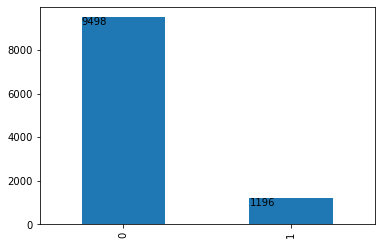

In [25]:
ax = data["label"].value_counts().plot(kind="bar")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), horizontalalignment= 'left',verticalalignment='top')

## 2. CLEANING

### 2.1 Removing links, tags, numbers and bias

In [26]:
cList = {
    "n't": " not",
    "/TD": " ",
    " PM ": " personal message ",
    " pm ": " personal message ",
    "PM ": "personal message ",
    " Donot ": " do not ",
    " MB ": " megabytes ",
}

c_re = re.compile("(%s)" % "|".join(cList.keys()))

In [27]:
def expand_contractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]

    return c_re.sub(replace, text)

In [28]:
data['text'] = data["text"].apply(lambda x: expand_contractions(x))

In [29]:
data['text'][3156]

"Classic trucker songs YouTube - & #x202a ; Dave Dudley - Diesel Smoke ( 18WoS : PTTM ) & #x202c ; & rlm ; Diesel Smoke another of same song  different video  says the artist was Red Simpson YouTube - & #x202a ; Red Simpson - Diesel smoke  & #x202c ; & rlm ; YouTube - & #x202a ; Red Sovine-Truck Drivin ' Son Of A Gun & #x202c ; & rlm ; Truck Drivin ' Son of a Gun YouTube - & #x202a ; Terry Allen - Amarillo Highway & #x202c ; & rlm ; Amarillo Highway ( slow version  live  with violins ) YouTube - & #x202a ; Robert Earl Keen - Amarillo Highway & #x202c ; & rlm ; Fast rockin ' country version by Robert Earl Keene"

In [30]:
pproc.clean("ciao prova stringa")

'ciao prova stringa'

In [31]:
data["text_clean"] = data["text"].apply(
    lambda x: pproc.clean(
        clean(
            pproc.clean(x),
            fix_unicode=True,  # fix various unicode errors
            to_ascii=True,  # transliterate to closest ASCII representation
            lower=True,  # lowercase text
            no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
            no_urls=True,  # replace all URLs with a special token
            no_emails=True,  # replace all email addresses with a special token
            no_phone_numbers=True,  # replace all phone numbers with a special token
            no_numbers=True,  # replace all numbers with a special token
            no_digits=True,  # replace all digits with a special token
            no_currency_symbols=True,  # replace all currency symbols with a special token
            no_punct=True,
        )
    )
)

In [32]:
data['text_clean'][3156]

'classic trucker songs youtube dave dudley diesel smoke wos pttm rlm diesel smoke another of same song different video says the artist was red simpson youtube red simpson diesel smoke rlm youtube red sovinetruck drivin son of a gun rlm truck drivin son of a gun youtube terry allen amarillo highway rlm amarillo highway slow version live with violins youtube robert earl keen amarillo highway rlm fast rockin country version by robert earl keene'

In [33]:
swords = set().union(stopwords.words("english"), string.punctuation)

data["text_clean"] = (
    data["text_clean"]
    .str.lower()
    .str.replace(r"(@[a-z0-9]+)\w+", " ")
    .str.replace(r"http\S+", "")
    .str.replace(r"www\S+", " ")
    .str.replace(r"com/watch", " ")
    .str.replace(r"\S*[.,:;!?-]\S*[^\s\.,:;!?-]", " ")
    .str.replace(r" th ", " ")
    .str.replace(r" th ", " ")
    .str.replace(r"\w*\d\w*", " ")
    .str.replace(r"rlm", " ")
    .str.replace(r"pttm", " ")
    .str.replace(r"ghlight", " ")
    .str.replace(r"[0-9]+(?:st| st|nd| nd|rd| rd|th| th)", "")
    .str.replace(r"([^a-z \t])", " ")
    .str.replace(r" +", " ")
    .apply(lambda x: " ".join([i for i in x.split() if not i in swords]))
)

In [34]:
data['text_clean'][3156]

'classic trucker songs youtube dave dudley diesel smoke wos diesel smoke another song different video says artist red simpson youtube red simpson diesel smoke youtube red sovinetruck drivin son gun truck drivin son gun youtube terry allen amarillo highway amarillo highway slow version live violins youtube robert earl keen amarillo highway fast rockin country version robert earl keene'

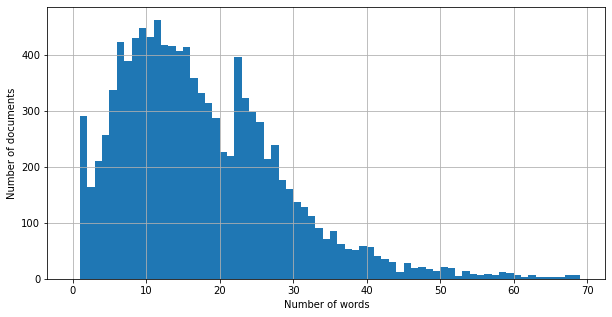

In [35]:
data['word_count_before'] = data['text'].apply(lambda x: len(x.split())) # Number of words in the string
plt.figure(figsize=(10,5))
plt.hist(data.word_count_before.values, bins = range(0, 70))
plt.xlabel("Number of words")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()

In [36]:
#data['char_count_before'] = data['text'].apply(len) # Number of characters in the string
#plt.figure(figsize=(10,5))
#plt.hist(data.char_count_before.values, bins = range(0, 50))
#plt.xlabel("Number of characters")
#plt.ylabel("Number of documents")
#plt.grid(True)
#plt.show()

In [37]:
#data['word_density_before'] = data['char_count_before'] / (data['word_count_before'] + 1) # Density of word (in char)

In [38]:
data['word_count'] = data['text_clean'].apply(lambda x: len(x.split()))
#data['char_count'] = data['text_clean'].apply(len)
#data['word_density'] = data['char_count'] / (data['word_count'] + 1) # Density of word (in char)

In [39]:
data['word_cleaning'] = data['word_count_before'] - data['word_count']
data.head()

,label,text,text_clean,word_count_before,word_count,word_cleaning
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting,16,5,11
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,34,19,15
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,15,9,6
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,22,12,10
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,14,6,8


In [40]:
data.head()

,label,text,text_clean,word_count_before,word_count,word_cleaning
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting,16,5,11
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,34,19,15
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,15,9,6
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,22,12,10
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,14,6,8


In [41]:
#data[data['text_clean'].str.contains("pm")]

### 2.2 Tokenization

In [42]:
# Stemming
ps = PorterStemmer()
data['stemmed'] = data['text_clean'].apply(lambda x: " ".join([ps.stem(i) for i in word_tokenize(x)]))

In [43]:
# Lemmatizer
lm = nltk.WordNetLemmatizer()
data['lemmatized'] = data['text_clean'].apply(lambda x: " ".join([lm.lemmatize(i) for i in word_tokenize(x)]))

In [44]:
# Tokens
data['tokens'] = data['lemmatized'].apply(word_tokenize)

### 2.3 Language Detection

In [291]:
def detect_language(x):
    try:
        return detect(x)
    except:
        return None

In [295]:
languages = data["text_clean"].progress_apply(lambda x: detect_language(x))

TypeError: list indices must be integers or slices, not str

In [279]:
df = pd.DataFrame(languages)
pd.DataFrame(df['text'].tolist(), index=df.index, columns = ["text", "language"])

,text,language
0,As of March 13th 2014 the booklet had been d...,en
1,In order to help increase the booklets downloa...,en
2,( Simply copy and paste the following text int...,en
3,Click below for a FREE download of a colorfull...,en
4,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,en
...,...,...
10921,Billy - `` That guy would not leave me alone ...,en
10922,Wish we at least had a Marine Le Pen to vote f...,en
10923,Its like the choices are white genocide candid...,en
10924,Why White people used to say that sex was a si...,en


In [289]:
lang_counter = {}
for lang in df['language']:
    if lang in lang_counter:
        lang_counter[lang] += 1
    else:
        lang_counter[lang] = 1

In [290]:
lang_counter_text

{'text': 10694, 'language': 10694}

In [48]:
data["lang_lem"] = data["lemmatized"].progress_apply(lambda x: detect_language(x))

In [49]:
data['lang_lem']

0        en
1        en
2        en
3        en
4        en
         ..
10921    en
10922    en
10923    en
10924    en
10925    nl
Name: lang_lem, Length: 10694, dtype: object

In [282]:
lang_counter = {}
for lang in all_adjs:
    if lang in lang_counter:
        lang_counter[lang] += 1
    else:
        lang_counter[lang] = 1

TypeError: list indices must be integers or slices, not str

In [229]:
lang_counter

{'en': 8302,
 'pl': 72,
 'it': 162,
 'fr': 183,
 'af': 264,
 'nl': 163,
 'tl': 111,
 'no': 151,
 'lv': 5,
 'es': 61,
 None: 147,
 'da': 133,
 'so': 92,
 'ro': 127,
 'tr': 32,
 'sv': 58,
 'ca': 52,
 'cy': 126,
 'sl': 32,
 'sq': 19,
 'fi': 55,
 'vi': 12,
 'cs': 17,
 'lt': 10,
 'et': 83,
 'id': 71,
 'hr': 36,
 'pt': 28,
 'sk': 25,
 'sw': 18,
 'hu': 12,
 'de': 35}

In [235]:
other_lang = []
for x in tqdm(range(len(data['lemmatized']))):
    try:
        if detect(x) != 'en':
            other.append([data['file_id'][x], data['lemmatized'][x], detect(data['lemmatized'][x])])
    except:
        None

In [234]:
other_lang

[]

In [50]:
data.head()

,label,text,text_clean,word_count_before,word_count,word_cleaning,stemmed,lemmatized,tokens,lang,lang_lem
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting,16,5,11,march booklet download time count,march booklet downloaded time counting,"[march, booklet, downloaded, time, counting]",en,en
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,34,19,15,order help increas booklet download would grea...,order help increase booklet downloads would gr...,"[order, help, increase, booklet, downloads, wo...",en,en
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,15,9,6,simpli copi past follow text youtub video desc...,simply copy paste following text youtube video...,"[simply, copy, paste, following, text, youtube...",en,en
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,22,12,10,click free download color illustr page ebook z...,click free download colorfully illustrated pag...,"[click, free, download, colorfully, illustrate...",en,en
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,14,6,8,click download megabyt green banner link,click download megabyte green banner link,"[click, download, megabyte, green, banner, link]",en,en


### 2.4 Bow and Tfidf

In [45]:
# Bow vectorizer
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['lemmatized'])
#print(bow_vectorizer.get_feature_names())

In [46]:
# Tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['lemmatized'])
#print(tfidf_vectorizer.get_feature_names())

In [47]:
Xa = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
dictionary = ['white', 'black', 'kill', 'kid', 'school','student']
A = Xa[dictionary]
A[10:25]

,white,black,kill,kid,school,student
10,0.117830,0.150073,0.243214,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,0.301993,0.000000,0.000000,0.000000,0.000000,0.000000
18,0.137300,0.000000,0.000000,0.000000,0.000000,0.000000
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [48]:
#pd.DataFrame(X_tfidf[20:50, 58:70].toarray(), columns=list(tfidf_vectorizer.vocabulary_.keys())[58:70])

## 3. TOP WORDS

In [49]:
# https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [50]:
common_words = get_top_n_words(data['lemmatized'], 50)
cmw = {word: freq for word, freq in common_words}

In [51]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]
mcw[:20] # Most common words between lemmatized words and frequencies

,words,freq
0,white,1440
1,like,788
2,people,616
3,black,589
4,one,551
5,get,514
6,would,513
7,youtube,453
8,time,393
9,year,387


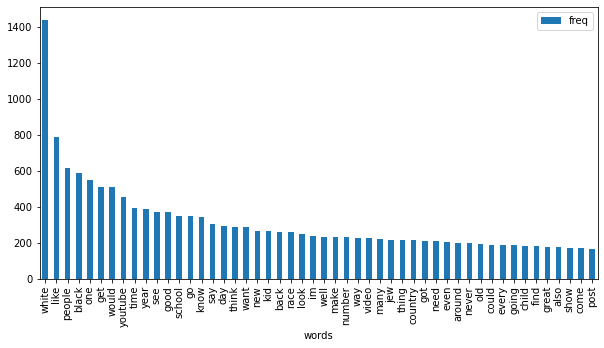

In [52]:
mcw.plot(x="words", y="freq", kind="bar", figsize=(10,5))
plt.show()

### 3.1 Part of speech (POS)

In [53]:
def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

In [54]:
print(TextBlob(data.iloc[4]["text_clean"]).tags)
print(TextBlob(data.iloc[4]["stemmed"]).tags)

[('click', 'NN'), ('download', 'NN'), ('megabytes', 'VBZ'), ('green', 'JJ'), ('banner', 'NN'), ('link', 'NN')]
[('click', 'NN'), ('download', 'NN'), ('megabyt', 'NN'), ('green', 'JJ'), ('banner', 'NN'), ('link', 'NN')]


In [55]:
data['POS_spacy'] = data['lemmatized'].progress_apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])

In [56]:
all_pos = data['POS_spacy'].sum()

In [57]:
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]

In [58]:
hate = data.loc[data["label"] == 1]

In [59]:
all_pos_hate = hate['POS_spacy'].sum()

In [60]:
all_adjs_hate = [x[0] for x in all_pos_hate if x[1] == "ADJ"]
all_nouns_hate = [x[0] for x in all_pos_hate if x[1] == "NOUN"]

### 3.2 Top Adjectives

In [61]:
adj_counter = {}
for word in all_adjs:
    if word in adj_counter:
        adj_counter[word] += 1
    else:
        adj_counter[word] = 1

top_20_adj = {k: v for k, v in sorted(adj_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj, orient="index", columns=["Freq"]).reset_index()

In [62]:
adj_counter1 = {}
for word in all_adjs_hate:
    if word in adj_counter1:
        adj_counter1[word] += 1
    else:
        adj_counter1[word] = 1
            
top_20_adj1 = {k: v for k, v in sorted(adj_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj1, orient="index", columns=["Freq"]).reset_index()

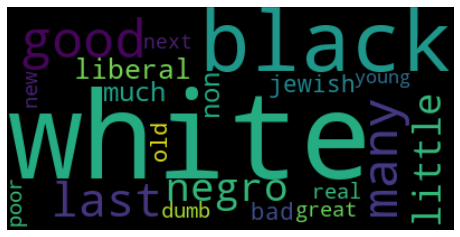

In [63]:
from wordcloud import WordCloud
wc_a_hate = WordCloud().generate_from_frequencies(top_20_adj1)
plt.figure(figsize=(8,5))
plt.imshow(wc_a_hate, interpolation="bilinear")
plt.axis("off")
plt.show()

In [64]:
top_adj = {"Total": top_20_adj.keys(), "Freq_Total": top_20_adj.values(), "Hate_Speech": top_20_adj1.keys(), "Freq_Hate": top_20_adj1.values()}
top_adj = pd.DataFrame(top_adj)
top_adj["R_Freq_Total"] = top_adj.apply(lambda x: np.round(x.Freq_Total / top_adj.Freq_Total.sum(), 3), axis=1)
top_adj["R_Freq_Hate"] = top_adj.apply(lambda x: np.round(x.Freq_Hate / top_adj.Freq_Hate.sum(), 3), axis=1)
top_adj = top_adj.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_adj

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,white,0.242,white,0.283
1,black,0.125,black,0.207
2,good,0.097,good,0.054
3,many,0.064,many,0.048
4,new,0.052,last,0.042
5,old,0.051,negro,0.039
6,last,0.046,little,0.035
7,great,0.042,liberal,0.032
8,little,0.033,much,0.030
9,much,0.032,non,0.030


In [65]:
common_adj = list(set(top_adj["Hate_Speech"].values).union(set(top_adj["Total"].values)))

In [66]:
freq_common_tot_adj = [adj_counter[x] for x in common_adj]
freq_common_hate_adj = [adj_counter1[x] for x in common_adj]

In [67]:
common_adj_df = pd.DataFrame({"Adj" : common_adj, "Freq_Tot": freq_common_tot_adj, "Freq_Hate_Speech": freq_common_hate_adj })

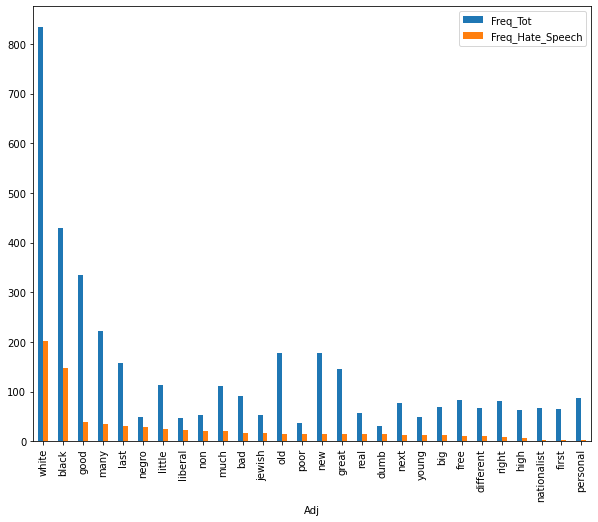

In [68]:
common_adj_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)
common_adj_df.plot(x='Adj', y=['Freq_Tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,8))
plt.show()

### 3.3 Top Nouns

In [69]:
noun_counter = {}
for word in all_nouns:
    if word in noun_counter:
        noun_counter[word] += 1
    else:
        noun_counter[word] = 1
            
top_20_noun = {k: v for k, v in sorted(noun_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun, orient="index", columns=["Freq"]).reset_index()

In [70]:
noun_counter1 = {}
for word in all_nouns_hate:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
top_20_noun1 = {k: v for k, v in sorted(noun_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun1, orient="index", columns=["Freq"]).reset_index()

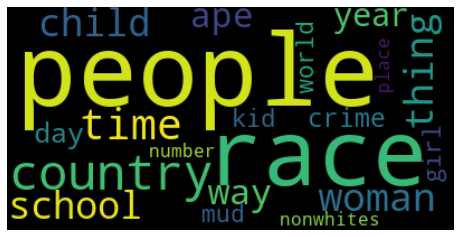

In [71]:
wc_n_hate = WordCloud().generate_from_frequencies(top_20_noun1)
plt.figure(figsize=(8,5))
plt.imshow(wc_n_hate, interpolation="bilinear")
plt.axis("off")
plt.show()

In [72]:
top_noun = {"Total": top_20_noun.keys(), "Freq_Total": top_20_noun.values(), "Hate_Speech": top_20_noun1.keys(), "Freq_Hate": top_20_noun1.values()}
top_noun = pd.DataFrame(top_noun)
top_noun["R_Freq_Total"] = top_noun.apply(lambda x: np.round(x.Freq_Total / top_noun.Freq_Total.sum(), 3), axis=1)
top_noun["R_Freq_Hate"] = top_noun.apply(lambda x: np.round(x.Freq_Hate / top_noun.Freq_Hate.sum(), 3), axis=1)
top_noun = top_noun.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_noun

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,people,0.142,people,0.135
1,time,0.084,race,0.110
2,year,0.084,country,0.088
3,school,0.062,time,0.065
4,race,0.057,woman,0.054
5,day,0.054,thing,0.052
6,number,0.052,child,0.048
7,thing,0.047,school,0.048
8,country,0.046,way,0.047
9,video,0.043,ape,0.045


In [73]:
common_nouns = list(set(top_noun["Hate_Speech"].values).union(set(top_noun["Total"].values)))

In [74]:
freq_common_noun_tot = [noun_counter[x] for x in common_nouns]
freq_common_noun_hate = [noun_counter1[x] for x in common_nouns]

In [75]:
common_noun_df = pd.DataFrame({"Nouns" : common_nouns, "Freq_Tot": freq_common_noun_tot, "Freq_Hate_Speech": freq_common_noun_hate })

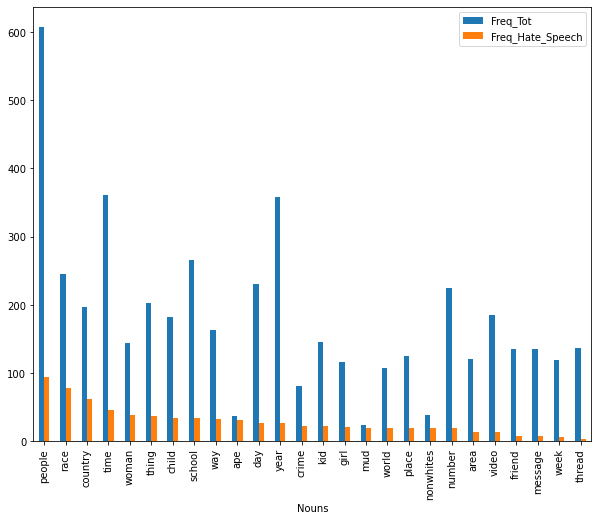

In [76]:
common_noun_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)
common_noun_df.plot('Nouns', y=['Freq_Tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,8))
plt.show()

### 3.2 Top Proper Noun

In [77]:
all_propn = [x[0] for x in all_pos if x[1] == "PROPN"]
all_propn_hate = [x[0] for x in all_pos_hate if x[1] == "PROPN"]

In [78]:
propn_counter = {}
for word in all_propn:
    if word in propn_counter:
        propn_counter[word] += 1
    else:
        propn_counter[word] = 1

top_20_propn = {k: v for k, v in sorted(propn_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_propn, orient="index", columns=["Freq"]).reset_index()

In [79]:
propn_counter1 = {}
for word in all_propn_hate:
    if word in propn_counter1:
        propn_counter1[word] += 1
    else:
        propn_counter1[word] = 1
            
top_20_propn1 = {k: v for k, v in sorted(propn_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_propn1, orient="index", columns=["Freq"]).reset_index()

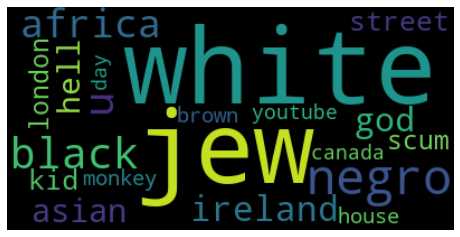

In [80]:
wc_p_hate = WordCloud().generate_from_frequencies(top_20_propn1)
plt.figure(figsize=(8,5))
plt.imshow(wc_p_hate, interpolation="bilinear")
plt.axis("off")
plt.show()

In [81]:
top_propn = {"Total": top_20_propn.keys(), "Freq_Total": top_20_propn.values(), "Hate_Speech": top_20_propn1.keys(), "Freq_Hate": top_20_propn1.values()}
top_propn = pd.DataFrame(top_propn)
top_propn["R_Freq_Total"] = top_propn.apply(lambda x: np.round(x.Freq_Total / top_propn.Freq_Total.sum(), 3), axis=1)
top_propn["R_Freq_Hate"] = top_propn.apply(lambda x: np.round(x.Freq_Hate / top_propn.Freq_Hate.sum(), 3), axis=1)
top_propn = top_propn.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_propn

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,white,0.212,white,0.192
1,youtube,0.130,jew,0.174
2,u,0.081,negro,0.089
3,jew,0.078,black,0.063
4,black,0.051,u,0.060
5,ireland,0.046,africa,0.052
6,god,0.039,ireland,0.041
7,kid,0.038,god,0.040
8,negro,0.036,asian,0.036
9,new,0.032,hell,0.033


In [82]:
common_propn = list(set(top_propn["Hate_Speech"].values).union(set(top_propn["Total"].values)))

In [83]:
freq_common_propn_tot = [propn_counter[x] for x in common_propn]
freq_common_propn_hate = [propn_counter1[x] for x in common_propn]

In [84]:
common_propn_df = pd.DataFrame({"Proper Nouns" : common_propn, "Freq_Tot": freq_common_propn_tot, "Freq_Hate_Speech": freq_common_propn_hate })

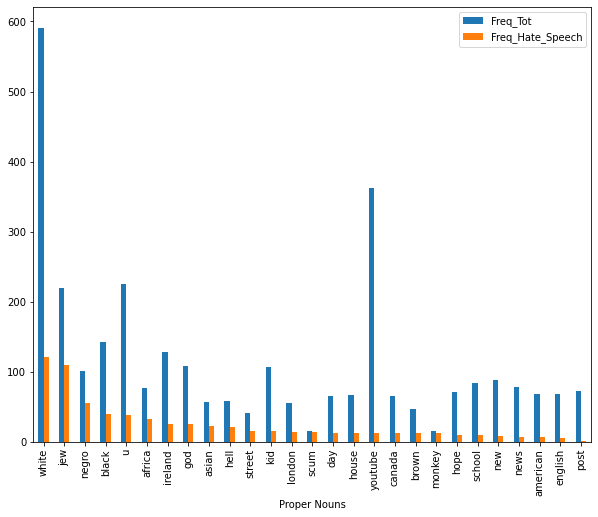

In [85]:
common_propn_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)
common_propn_df.plot('Proper Nouns', y=['Freq_Tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,8))
plt.show()

### 3.4 Top POS

In [86]:
pos_counter = {}
for x in all_pos:
    if x[1] in pos_counter:
        pos_counter[x[1]] += 1
    else:
        pos_counter[x[1]] = 1
        
top_pos = {k: v for k, v in sorted(pos_counter.items(), key=lambda item: item[1], reverse=True)}

In [87]:
freq_pos = pd.DataFrame.from_dict(top_pos, orient="index", columns=["Freq"]).reset_index()
freq_pos["R_Freq"] = freq_pos.apply(lambda x: np.round(x.Freq / freq_pos.Freq.sum(), 2), axis=1)

In [88]:
pos_counter_hate = {}
for x in all_pos_hate:
    if x[1] in pos_counter_hate:
        pos_counter_hate[x[1]] += 1
    else:
        pos_counter_hate[x[1]] = 1
        
top_pos_hate = {k: v for k, v in sorted(pos_counter_hate.items(), key=lambda item: item[1], reverse=True)}

In [89]:
freq_pos_hate = pd.DataFrame.from_dict(top_pos_hate, orient="index", columns=["Freq"]).reset_index()
freq_pos_hate["R_Freq"] = freq_pos_hate.apply(lambda x: np.round(x.Freq / freq_pos_hate.Freq.sum(), 2), axis=1)

In [90]:
compared_pos = {"Total": top_pos.keys(), "Freq_Total": top_pos.values(), "Hate_Speech": top_pos_hate.keys(), "Freq_Hate": top_pos_hate.values()}
compared_pos = pd.DataFrame(compared_pos)
compared_pos["R_Freq_Total"] = compared_pos.apply(lambda x: np.round(x.Freq_Total / compared_pos.Freq_Total.sum(), 3), axis=1)
compared_pos["R_Freq_Hate"] = compared_pos.apply(lambda x: np.round(x.Freq_Hate / compared_pos.Freq_Hate.sum(), 3), axis=1)
compared_pos = compared_pos.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
compared_pos

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,NOUN,0.291,NOUN,0.290
1,PROPN,0.236,VERB,0.219
2,VERB,0.206,PROPN,0.210
3,ADJ,0.132,ADJ,0.151
4,ADV,0.059,ADV,0.061
5,PRON,0.015,PRON,0.013
6,INTJ,0.012,SCONJ,0.012
7,SCONJ,0.011,NUM,0.010
8,NUM,0.011,INTJ,0.008
9,ADP,0.008,ADP,0.007


In [91]:
def filter_text_pos(x):
    final_pos_text = []
    for elem in x:
        for pos in pos_list:
            if elem[1] == pos:
                final_pos_text.append(elem[0])
    
    return " ".join(final_pos_text)

In [92]:
pos_list = ["NOUN"]
data["NOUN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['NOUN_count'] = data['NOUN'].apply(lambda x: len(x.split()))

In [93]:
pos_list = ["PROPN"]
data["PROPN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['PROPN_count'] = data['PROPN'].apply(lambda x: len(x.split()))

In [94]:
pos_list = ["VERB"]
data["VERB"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['VERB_count'] = data['VERB'].apply(lambda x: len(x.split()))

In [95]:
pos_list = ["ADJ"]
data["ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['ADJ_count'] = data['ADJ'].apply(lambda x: len(x.split()))

In [96]:
pos_list = ["ADV"]
data["ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['ADV_count'] = data['ADV'].apply(lambda x: len(x.split()))

In [97]:
pos_list = ["PRON"]
data["PRON"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['PRON_count'] = data['PRON'].apply(lambda x: len(x.split()))

In [98]:
pos_list = ["SCONJ"]
data["SCONJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['SCONJ_count'] = data['SCONJ'].apply(lambda x: len(x.split()))

In [99]:
pos_list = ["INTJ"]
data["INTJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['INTJ_count'] = data['SCONJ'].apply(lambda x: len(x.split()))

In [100]:
data.head()

,label,text,text_clean,word_count_before,word_count,word_cleaning,stemmed,lemmatized,tokens,POS_spacy,...,ADJ,ADJ_count,ADV,ADV_count,PRON,PRON_count,SCONJ,SCONJ_count,INTJ,INTJ_count
0,0,As of March 13th 2014 the booklet had been d...,march booklet downloaded times counting,16,5,11,march booklet download time count,march booklet downloaded time counting,"[march, booklet, downloaded, time, counting]","[(march, PROPN), (booklet, PROPN), (downloaded...",...,,0,,0,,0,,0,,0
1,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,34,19,15,order help increas booklet download would grea...,order help increase booklet downloads would gr...,"[order, help, increase, booklet, downloads, wo...","[(order, NOUN), (help, VERB), (increase, VERB)...",...,booklet great,2,,0,,0,,0,,0
2,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,15,9,6,simpli copi past follow text youtub video desc...,simply copy paste following text youtube video...,"[simply, copy, paste, following, text, youtube...","[(simply, ADV), (copy, VERB), (paste, NOUN), (...",...,,0,simply,1,,0,,0,,0
3,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,22,12,10,click free download color illustr page ebook z...,click free download colorfully illustrated pag...,"[click, free, download, colorfully, illustrate...","[(click, VERB), (free, ADJ), (download, NOUN),...",...,free intentional western,3,colorfully,1,,0,,0,,0
4,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,14,6,8,click download megabyt green banner link,click download megabyte green banner link,"[click, download, megabyte, green, banner, link]","[(click, VERB), (download, PROPN), (megabyte, ...",...,,0,,0,,0,,0,,0


## 4. FEATURE SELECTION

In [101]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X_feature = data.loc[:, ["word_count_before","word_count", "word_cleaning", "NOUN_count", "PROPN_count", "VERB_count", "ADJ_count", "ADV_count", "PRON_count", "SCONJ_count", "INTJ_count"]]
y_feature = data['label']

scaler = StandardScaler()
X_feature_scaled = scaler.fit_transform(X_feature)

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, n_features_to_select = 3)
fit = rfe.fit(X_feature_scaled, y_feature)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [False False False False False  True  True  True False False False]
Feature Ranking: [7 4 3 6 5 1 1 1 2 9 8]


In [102]:
# Either scale from the beginning to [0, 1]
# or drop this, since it does not accept negative values.
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X_feature, y_feature)
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X_feature)
print(features[0:5,:])

[2498.673 1292.699 1212.811  364.007   97.961  418.227  427.497   98.572
    3.897   24.876   24.876]
[[16  5 11]
 [34 19 15]
 [15  9  6]
 [22 12 10]
 [14  6  8]]


In [103]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_feature_scaled, y_feature)
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)
print ("Ridge model:", ridge.coef_)

Ridge model: [-0.012 -0.042  0.017  0.014  0.023  0.042  0.043  0.014 -0.007  0.004
  0.004]


## 5. MODELS

In [104]:
tfidf_vectorizer = TfidfVectorizer()
X_class = tfidf_vectorizer.fit_transform(data['lemmatized'])
y_class = data["label"]
X_class.shape

(10694, 13228)

In [105]:
random_state = np.random.RandomState(0)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)


Multinomial Naive Bayes - Original dataset

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2850
           1       0.33      0.20      0.25       359

    accuracy                           0.86      3209
   macro avg       0.62      0.57      0.59      3209
weighted avg       0.84      0.86      0.85      3209

0.8647553755063883


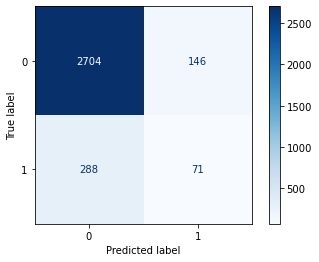

In [107]:
# Multinomial Naive Bayes
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train)
y_mnb = mnb.predict(X_test)
as_mnb = accuracy_score(y_test, y_mnb)
f1s_mnb = f1_score(y_test, y_mnb, average= "macro")
prec_mnb = precision_score(y_test, y_mnb)
rec_mnb = recall_score(y_test, y_mnb, average='macro')
print("\nMultinomial Naive Bayes - Original dataset\n")
plot_confusion_matrix(mnb, X_test,y_test, cmap= "Blues")
#print(confusion_matrix(y_test,y_mnb))
print(classification_report(y_test,y_mnb))
print(accuracy_score(y_test, y_mnb))

[LibSVM]
Support Vector Machine - Original dataset

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2850
           1       0.69      0.03      0.05       359

    accuracy                           0.89      3209
   macro avg       0.79      0.51      0.49      3209
weighted avg       0.87      0.89      0.84      3209

0.8896852602056715


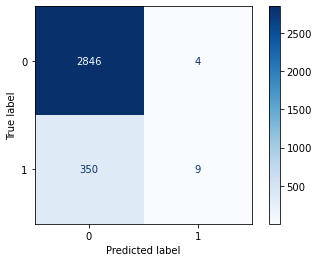

In [108]:
# Support Vector Machine
svc = SVC(verbose=10, random_state=42)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)
as_svc = accuracy_score(y_test, y_svc)
f1s_svc = f1_score(y_test, y_svc, average="macro")
prec_svc = precision_score(y_test, y_svc)
rec_svc = recall_score(y_test, y_svc, average='macro')
print("\nSupport Vector Machine - Original dataset\n")
plot_confusion_matrix(svc, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))


Logistic Regression - Original dataset

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2850
           1       0.63      0.03      0.06       359

    accuracy                           0.89      3209
   macro avg       0.76      0.52      0.50      3209
weighted avg       0.86      0.89      0.84      3209

0.8896852602056715


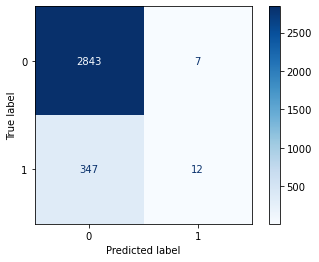

In [109]:
# Logistic
log_fit = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log = log_fit.predict(X_test)
as_log = accuracy_score(y_test, y_log)
f1s_log = f1_score(y_test, y_log, average= "macro")
prec_log = precision_score(y_test, y_log)
rec_log = recall_score(y_test, y_log, average='macro')
print("\nLogistic Regression - Original dataset\n")
plot_confusion_matrix(log_fit, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log))
print(classification_report(y_test,y_log))
print(accuracy_score(y_test, y_log))


Random Forest - Original dataset

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      2850
           1       0.72      0.07      0.13       359

    accuracy                           0.89      3209
   macro avg       0.81      0.53      0.54      3209
weighted avg       0.88      0.89      0.85      3209

0.893113119351823


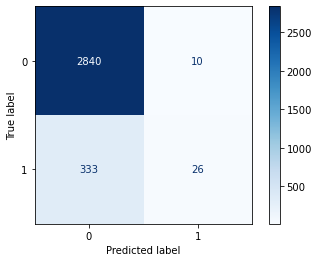

In [110]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train) 
y_rf = rf.predict(X_test)
as_rf = accuracy_score(y_test, y_rf)
f1s_rf = f1_score(y_test, y_rf, average= "macro")
prec_rf = precision_score(y_test, y_rf)
rec_rf = recall_score(y_test, y_rf, average='macro')
print("\nRandom Forest - Original dataset\n")
plot_confusion_matrix(rf, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf))
print(classification_report(y_test,y_rf))
print(accuracy_score(y_test, y_rf))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - Original dataset

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2850
           1       0.47      0.27      0.34       359

    accuracy                           0.88      3209
   macro avg       0.69      0.62      0.64      3209
weighted avg       0.86      0.88      0.87      3209

0.8846992832658149


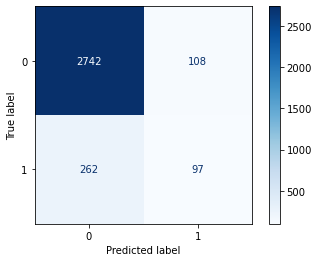

In [111]:
# Neural Networks
NN = MLPClassifier(random_state=42, max_iter=30)
NN.fit(X_train, y_train)
y_NN = NN.predict(X_test)
as_NN = accuracy_score(y_test, y_NN)
f1s_NN = f1_score(y_test, y_NN, average= "macro")
prec_NN = precision_score(y_test, y_NN)
rec_NN = recall_score(y_test, y_NN, average='macro')
print("\nNeural Networks - Original dataset\n")
plot_confusion_matrix(NN, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN))
print(classification_report(y_test,y_NN))
print(accuracy_score(y_test, y_NN))


Decision Tree - Original dataset

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2850
           1       0.38      0.32      0.35       359

    accuracy                           0.87      3209
   macro avg       0.65      0.63      0.64      3209
weighted avg       0.86      0.87      0.86      3209

0.8653786226238703


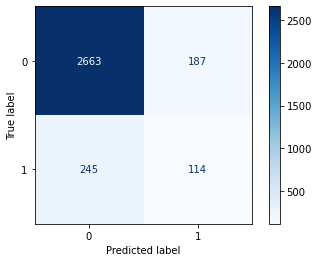

In [112]:
# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)
as_tree = accuracy_score(y_test, y_tree)
f1s_tree = f1_score(y_test, y_tree, average= "macro")
prec_tree = precision_score(y_test, y_tree)
rec_tree = recall_score(y_test, y_tree, average='macro')
print("\nDecision Tree - Original dataset\n")
plot_confusion_matrix(tree, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree))
print(classification_report(y_test,y_tree))
print(accuracy_score(y_test, y_tree))


K-Nearest Neighbors - Original dataset

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2850
           1       0.50      0.00      0.01       359

    accuracy                           0.89      3209
   macro avg       0.69      0.50      0.47      3209
weighted avg       0.84      0.89      0.84      3209

0.8881271424119663


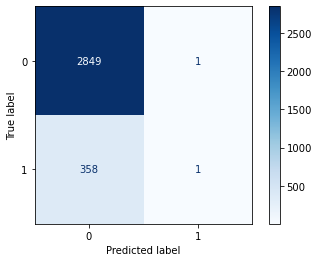

In [113]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)
as_knn = accuracy_score(y_test, y_knn)
f1s_knn = f1_score(y_test, y_knn, average= "macro")
prec_knn = precision_score(y_test, y_knn)
rec_knn = recall_score(y_test, y_knn, average='macro')
print("\nK-Nearest Neighbors - Original dataset\n")
plot_confusion_matrix(knn, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn))
print(classification_report(y_test,y_knn))
print(accuracy_score(y_test, y_knn))

In [114]:
s1 = pd.Series([as_mnb, as_svc, as_log, as_rf, as_NN, as_tree, as_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2 = pd.Series([f1s_mnb, f1s_svc, f1s_log, f1s_rf, f1s_NN, f1s_tree, f1s_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3 = pd.Series([prec_mnb, prec_svc, prec_log, prec_rf, prec_NN, prec_tree, prec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4 = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d = {'Accuracy Score' : s1, 'Precision Score': s3, 'Recall Score' : s4, 'F1 Score' : s2 }
dfm = pd.DataFrame(d)
print("\nOriginal dataset\n")
dfm.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


Original dataset



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.864755,0.327189,0.573272,0.586119
Support Vector Machine,0.889685,0.692308,0.511833,0.494918
Logistic Regression,0.889685,0.631579,0.515485,0.502441
Random Forest,0.893113,0.722222,0.534457,0.537349
Neural Networks,0.884699,0.473171,0.616150,0.640383
Decision Tree,0.865379,0.378738,0.625967,0.635214
K-Nearest Neighbors,0.888127,0.500000,0.501217,0.473135


### 5.1 Imbalanced

In [115]:
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

In [116]:
X_under, y_under = undersample.fit_resample(X_class, y_class)

In [117]:
print(Counter(y_under))

Counter({0: 1196, 1: 1196})


In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42, stratify=y_under)


Multinomoial Naive Bayes - Balanced dataset

              precision    recall  f1-score   support

           0       0.68      0.57      0.62       359
           1       0.63      0.74      0.68       359

    accuracy                           0.65       718
   macro avg       0.66      0.65      0.65       718
weighted avg       0.66      0.65      0.65       718

0.6532033426183844


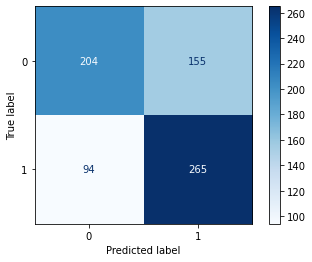

In [119]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print("\nMultinomoial Naive Bayes - Balanced dataset\n")
plot_confusion_matrix(mnb_i, X_test,y_test, cmap = "Blues")
#print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[LibSVM]
Support Vector Machine - Balanced dataset

              precision    recall  f1-score   support

           0       0.69      0.76      0.73       359
           1       0.74      0.66      0.70       359

    accuracy                           0.71       718
   macro avg       0.71      0.71      0.71       718
weighted avg       0.71      0.71      0.71       718

0.7116991643454039


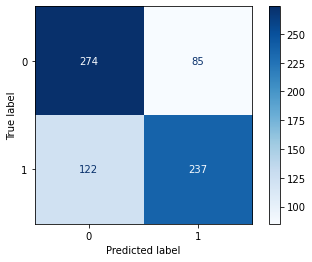

In [120]:
# Support Vector Machine
svc_i = SVC(verbose=10, random_state=42)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print("\nSupport Vector Machine - Balanced dataset\n")
plot_confusion_matrix(svc_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))


Logistic Regression - Balanced dataset

              precision    recall  f1-score   support

           0       0.71      0.75      0.73       359
           1       0.74      0.69      0.71       359

    accuracy                           0.72       718
   macro avg       0.72      0.72      0.72       718
weighted avg       0.72      0.72      0.72       718

0.7200557103064067


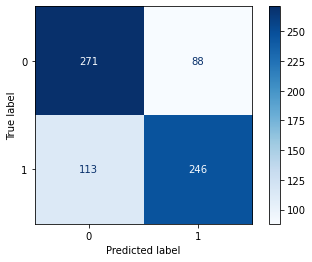

In [121]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print("\nLogistic Regression - Balanced dataset\n")
plot_confusion_matrix(log_fit_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))


Random Forest - Balanced dataset

              precision    recall  f1-score   support

           0       0.66      0.82      0.73       359
           1       0.76      0.57      0.65       359

    accuracy                           0.69       718
   macro avg       0.71      0.69      0.69       718
weighted avg       0.71      0.69      0.69       718

0.6949860724233984


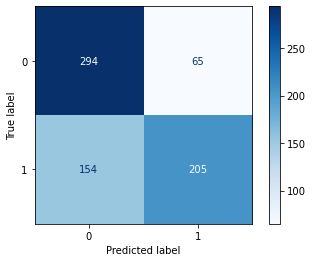

In [122]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print("\nRandom Forest - Balanced dataset\n")
plot_confusion_matrix(rf_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - Balanced dataset

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       359
           1       0.72      0.68      0.70       359

    accuracy                           0.70       718
   macro avg       0.71      0.70      0.70       718
weighted avg       0.71      0.70      0.70       718

0.7047353760445683


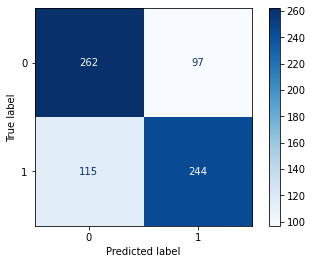

In [123]:
# Neural Networks
NN_i = MLPClassifier(random_state=42, max_iter=30)
NN_i.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN_i = NN_i.predict(X_test)
as_NN_i = accuracy_score(y_test, y_NN_i)
f1s_NN_i = f1_score(y_test, y_NN_i, average= "macro")
prec_NN_i = precision_score(y_test, y_NN_i)
rec_NN_i = recall_score(y_test, y_NN_i, average='macro')
print("\nNeural Networks - Balanced dataset\n")
plot_confusion_matrix(NN_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN_i))
print(classification_report(y_test,y_NN_i))
print(accuracy_score(y_test, y_NN_i))


Decision Tree - Balanced dataset

              precision    recall  f1-score   support

           0       0.68      0.71      0.69       359
           1       0.70      0.66      0.68       359

    accuracy                           0.69       718
   macro avg       0.69      0.69      0.69       718
weighted avg       0.69      0.69      0.69       718

0.6866295264623955


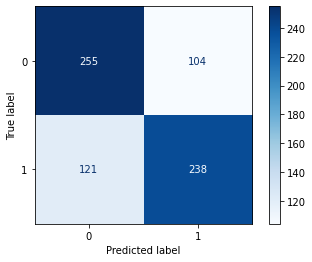

In [124]:
# Decision Tree
tree_i = DecisionTreeClassifier(random_state=42)
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print("\nDecision Tree - Balanced dataset\n")
plot_confusion_matrix(tree_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))


K-Nearest Neighbors - Balanced dataset

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       359
           1       1.00      0.00      0.01       359

    accuracy                           0.50       718
   macro avg       0.75      0.50      0.34       718
weighted avg       0.75      0.50      0.34       718

0.5013927576601671


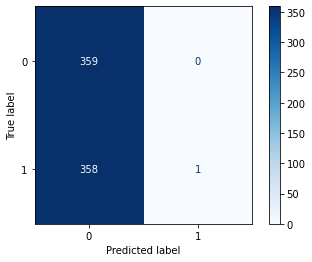

In [125]:
# K-Nearest Neighbors
knn_i = KNeighborsClassifier()
knn_i.fit(X_train, y_train)
y_knn_i = knn_i.predict(X_test)
as_knn_i = accuracy_score(y_test, y_knn_i)
f1s_knn_i = f1_score(y_test, y_knn_i, average= "macro")
prec_knn_i = precision_score(y_test, y_knn_i)
rec_knn_i = recall_score(y_test, y_knn_i, average='macro')
print("\nK-Nearest Neighbors - Balanced dataset\n")
plot_confusion_matrix(knn_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn_i))
print(classification_report(y_test,y_knn_i))
print(accuracy_score(y_test, y_knn_i))

In [126]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb_i, rec_svc_i, rec_log_i, rec_rf_i, rec_NN_i, rec_tree_i, rec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
print("\nBalanced dataset\n")
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


Balanced dataset



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.653203,0.630952,0.653203,0.650682
Support Vector Machine,0.711699,0.736025,0.711699,0.710932
Logistic Regression,0.720056,0.736527,0.720056,0.719716
Random Forest,0.694986,0.759259,0.694986,0.690226
Neural Networks,0.704735,0.715543,0.704735,0.704550
Decision Tree,0.686630,0.695906,0.686630,0.686454
K-Nearest Neighbors,0.501393,1.000000,0.501393,0.336421


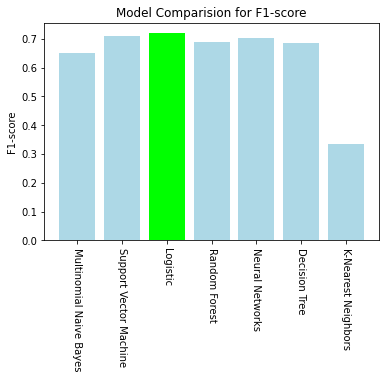

In [127]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors')
y_pos = np.arange(len(objects))
performance = [f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i]
clrs = ['lightblue' if (x < max(performance)) else 'lime' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('F1-score')
plt.title('Model Comparision for F1-score')
plt.show()

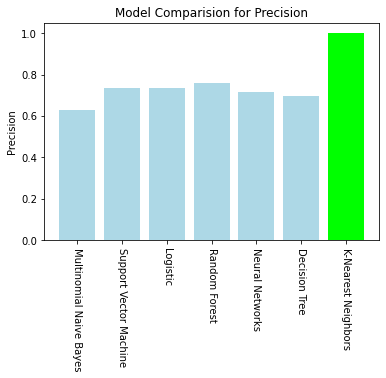

In [128]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors')
y_pos = np.arange(len(objects))
performance = [prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i]
clrs = ['lightblue' if (x < max(performance)) else 'lime' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('Precision')
plt.title('Model Comparision for Precision')
plt.show()

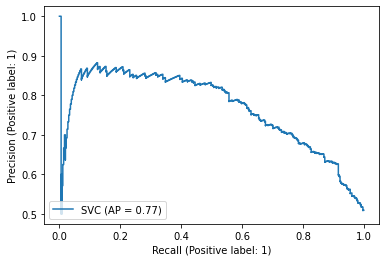

In [129]:
plot_precision_recall_curve(svc_i, X_test, y_test)

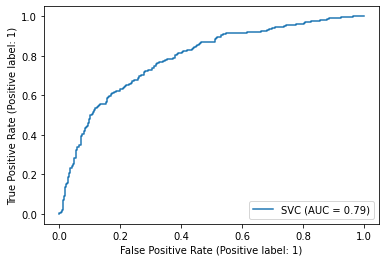

In [130]:
plot_roc_curve(svc_i,  X_test, y_test)

### 5.2 Models on POS

#### 5.2.1 Nouns + Proper Nouns + Adjectives + Adverbs

In [131]:
pos_list = ["NOUN" , "PROPN" ,"ADJ" ]

In [132]:
data["NOUN_PROPN_ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [133]:
tfidf_vectorizer = TfidfVectorizer()
X_Propn = tfidf_vectorizer.fit_transform(data["NOUN_PROPN_ADJ"])
y_Propn = data["label"]
X_Propn.shape

(10694, 10885)

In [134]:
X_over_p, y_over_p = undersample.fit_resample(X_Propn, y_Propn)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_over_p, y_over_p, test_size=0.3, random_state=42, stratify=y_over_p)


Multinomoial Naive Bayes - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.69      0.62      0.65       359
           1       0.65      0.73      0.69       359

    accuracy                           0.67       718
   macro avg       0.67      0.67      0.67       718
weighted avg       0.67      0.67      0.67       718

0.6713091922005571


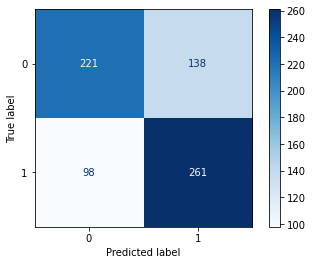

In [136]:
# Multinomial Naive Bayes
mnb_p = MultinomialNB(alpha=0.01)
mnb_p.fit(X_train, y_train)
y_mnb_p = mnb_p.predict(X_test)
as_mnb_p = accuracy_score(y_test, y_mnb_p)
f1s_mnb_p = f1_score(y_test, y_mnb_p, average= "macro")
prec_mnb_p = precision_score(y_test, y_mnb_p)
rec_mnb_p = recall_score(y_test, y_mnb_p, average='macro')
print("\nMultinomoial Naive Bayes - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(mnb_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_mnb_p))
print(classification_report(y_test,y_mnb_p))
print(accuracy_score(y_test, y_mnb_p))

[LibSVM]
Support Vector Machine - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       359
           1       0.74      0.69      0.71       359

    accuracy                           0.72       718
   macro avg       0.72      0.72      0.72       718
weighted avg       0.72      0.72      0.72       718

0.7228412256267409


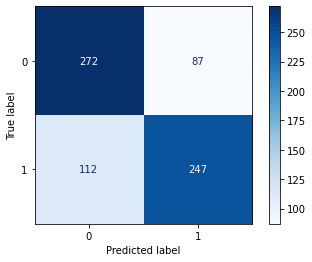

In [137]:
# Support Vector Machine
svc_p = SVC(verbose=10, random_state=42)
svc_p.fit(X_train, y_train)
y_svc_p = svc_p.predict(X_test)
as_svc_p = accuracy_score(y_test, y_svc_p)
f1s_svc_p = f1_score(y_test, y_svc_p, average="macro")
prec_svc_p = precision_score(y_test, y_svc_p)
rec_svc_p = recall_score(y_test, y_svc_p, average='macro')
print("\nSupport Vector Machine - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(svc_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_p))
print(classification_report(y_test,y_svc_p))
print(accuracy_score(y_test, y_svc_p))


Logistic Regression - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       359
           1       0.75      0.65      0.69       359

    accuracy                           0.71       718
   macro avg       0.72      0.71      0.71       718
weighted avg       0.72      0.71      0.71       718

0.7144846796657381


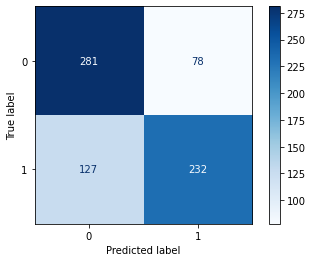

In [138]:
# Logistic
log_fit_p = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_p = log_fit_p.predict(X_test)
as_log_p = accuracy_score(y_test, y_log_p)
f1s_log_p = f1_score(y_test, y_log_p, average= "macro")
prec_log_p = precision_score(y_test, y_log_p)
rec_log_p = recall_score(y_test, y_log_p, average='macro')
print("\nLogistic Regression - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(log_fit_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_p))
print(classification_report(y_test,y_log_p))
print(accuracy_score(y_test, y_log_p))


Random Forest - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       359
           1       0.75      0.59      0.66       359

    accuracy                           0.70       718
   macro avg       0.71      0.70      0.69       718
weighted avg       0.71      0.70      0.69       718

0.6963788300835655


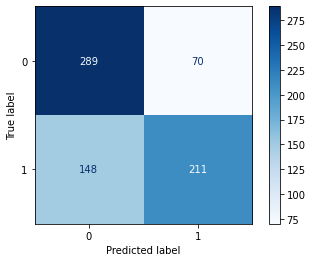

In [139]:
# Random Forest
rf_p = RandomForestClassifier(n_estimators=10, random_state=42)
rf_p.fit(X_train, y_train) 
y_rf_p = rf_p.predict(X_test)
as_rf_p = accuracy_score(y_test, y_rf_p)
f1s_rf_p = f1_score(y_test, y_rf_p, average= "macro")
prec_rf_p = precision_score(y_test, y_rf_p)
rec_rf_p = recall_score(y_test, y_rf_p, average='macro')
print("\nRandom Forest - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(rf_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_p))
print(classification_report(y_test,y_rf_p))
print(accuracy_score(y_test, y_rf_p))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.71      0.75      0.73       359
           1       0.74      0.70      0.72       359

    accuracy                           0.72       718
   macro avg       0.72      0.72      0.72       718
weighted avg       0.72      0.72      0.72       718

0.7228412256267409


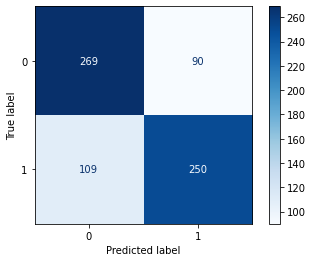

In [140]:
# Neural Networks
NN_p = MLPClassifier(random_state=42, max_iter=30)
NN_p.fit(X_train, y_train)
y_NN_p = NN_p.predict(X_test)
as_NN_p = accuracy_score(y_test, y_NN_p)
f1s_NN_p = f1_score(y_test, y_NN_p, average= "macro")
prec_NN_p = precision_score(y_test, y_NN_p)
rec_NN_p = recall_score(y_test, y_NN_p, average='macro')
print("\nNeural Networks - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(NN_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN_p))
print(classification_report(y_test,y_NN_p))
print(accuracy_score(y_test, y_NN_p))


Decision Tree - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       359
           1       0.75      0.65      0.70       359

    accuracy                           0.72       718
   macro avg       0.72      0.72      0.72       718
weighted avg       0.72      0.72      0.72       718

0.7172701949860725


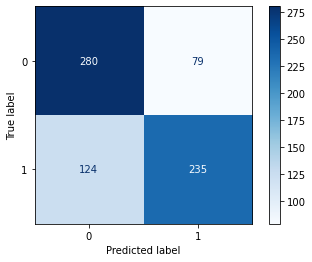

In [141]:
# Decision Tree
tree_p = DecisionTreeClassifier(random_state=42)
tree_p.fit(X_train, y_train)
y_tree_p = tree_p.predict(X_test)
as_tree_p = accuracy_score(y_test, y_tree_p)
f1s_tree_p = f1_score(y_test, y_tree_p, average= "macro")
prec_tree_p = precision_score(y_test, y_tree_p)
rec_tree_p = recall_score(y_test, y_tree_p, average='macro')
print("\nDecision Tree - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(tree_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_p))
print(classification_report(y_test,y_tree_p))
print(accuracy_score(y_test, y_tree_p))


K-Nearest Neighbors - NOUN_PROPN_ADJ

              precision    recall  f1-score   support

           0       0.50      0.98      0.66       359
           1       0.60      0.03      0.05       359

    accuracy                           0.50       718
   macro avg       0.55      0.50      0.36       718
weighted avg       0.55      0.50      0.36       718

0.5041782729805014


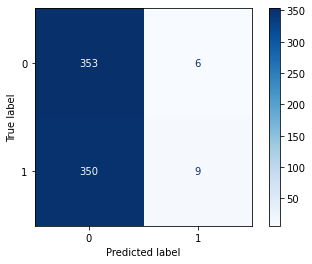

In [142]:
# K-Nearest Neighbors
knn_p = KNeighborsClassifier()
knn_p.fit(X_train, y_train)
y_knn_p = knn_p.predict(X_test)
as_knn_p = accuracy_score(y_test, y_knn_p)
f1s_knn_p = f1_score(y_test, y_knn_p, average= "macro")
prec_knn_p = precision_score(y_test, y_knn_p)
rec_knn_p = recall_score(y_test, y_knn_p, average='macro')
print("\nK-Nearest Neighbors - NOUN_PROPN_ADJ\n")
plot_confusion_matrix(knn_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn_p))
print(classification_report(y_test,y_knn_p))
print(accuracy_score(y_test, y_knn_p))

In [143]:
s1_p = pd.Series([as_mnb_p, as_svc_p, as_log_p, as_rf_p, as_NN_p, as_tree_p, as_knn_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_p = pd.Series([f1s_mnb_p, f1s_svc_p, f1s_log_p, f1s_rf_p, f1s_NN_p, f1s_tree_p, f1s_knn_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_p = pd.Series([prec_mnb_p, prec_svc_p, prec_log_p, prec_rf_p, prec_NN_p, prec_tree_p, prec_knn_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_p = pd.Series([rec_mnb_p, rec_svc_p, rec_log_p, rec_rf_p, rec_NN_p, rec_tree_p, rec_knn_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_p = {'Accuracy Score' : s1_p, 'Precision Score': s3_p, 'Recall Score' : s4_p, 'F1 Score' : s2_p}
dfm_p = pd.DataFrame(d_p)
print("\nNOUN_PROPN_ADJ\n")
dfm_p.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


NOUN_PROPN_ADJ



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.671309,0.654135,0.671309,0.670286
Support Vector Machine,0.722841,0.739521,0.722841,0.722505
Logistic Regression,0.714485,0.748387,0.714485,0.713149
Random Forest,0.696379,0.750890,0.696379,0.692753
Neural Networks,0.722841,0.735294,0.722841,0.722647
Decision Tree,0.717270,0.748408,0.717270,0.716155
K-Nearest Neighbors,0.504178,0.600000,0.504178,0.356456


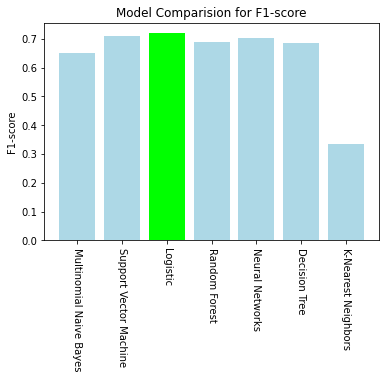

In [144]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors')
y_pos = np.arange(len(objects))
performance = [f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i]
clrs = ['lightblue' if (x < max(performance)) else 'lime' for x in performance ]
plt.bar(y_pos, performance, align='center',  color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('F1-score')
plt.title('Model Comparision for F1-score')
plt.show()

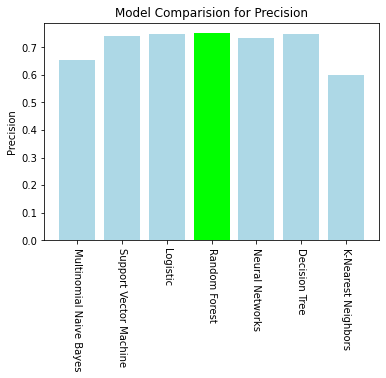

In [145]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors')
y_pos = np.arange(len(objects))
performance = [prec_mnb_p, prec_svc_p, prec_log_p, prec_rf_p, prec_NN_p, prec_tree_p, prec_knn_p]
clrs = ['lightblue' if (x < max(performance)) else 'lime' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('Precision')
plt.title('Model Comparision for Precision')
plt.show()

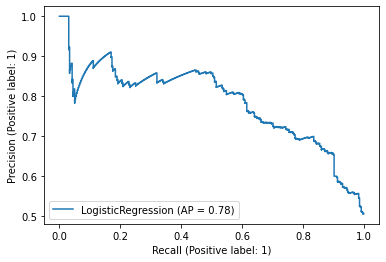

In [146]:
plot_precision_recall_curve(log_fit_p, X_test, y_test)

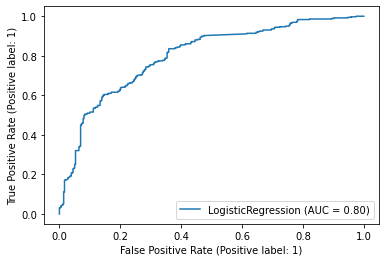

In [147]:
plot_roc_curve(log_fit_p,  X_test, y_test)

#### 5.2.2 Nouns + Proper Nouns + Verbs + Adjectives + Adverbs

In [148]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "DET"]

In [149]:
data["NOUN_PROPN_VERB_ADJ_ADV_DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [150]:
tfidf_vectorizer = TfidfVectorizer()
X_NounPropnVerb = tfidf_vectorizer.fit_transform(data["NOUN_PROPN_VERB_ADJ_ADV_DET"])
y_NounPropnVerb = data["label"]
X_NounPropnVerb.shape

(10694, 13058)

In [151]:
X_over_n, y_over_n = undersample.fit_resample(X_NounPropnVerb, y_NounPropnVerb)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X_over_n, y_over_n, test_size=0.3, random_state=42, stratify=y_over_n)


Multinomoial Naive Bayes - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.69      0.57      0.62       359
           1       0.63      0.74      0.68       359

    accuracy                           0.65       718
   macro avg       0.66      0.65      0.65       718
weighted avg       0.66      0.65      0.65       718

0.6545961002785515


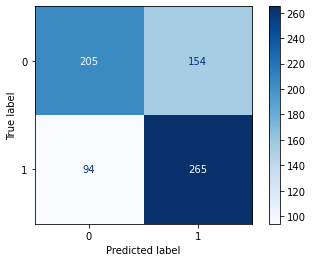

In [153]:
# Multinomial Naive Bayes
mnb_n = MultinomialNB(alpha=0.01)
mnb_n.fit(X_train, y_train)
y_mnb_n = mnb_n.predict(X_test)
as_mnb_n = accuracy_score(y_test, y_mnb_n)
f1s_mnb_n = f1_score(y_test, y_mnb_n, average= "macro")
prec_mnb_n = precision_score(y_test, y_mnb_n)
rec_mnb_n = recall_score(y_test, y_mnb_n, average='macro')
print("\nMultinomoial Naive Bayes - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(mnb_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_mnb_n))
print(classification_report(y_test,y_mnb_n))
print(accuracy_score(y_test, y_mnb_n))

[LibSVM]
Support Vector Machine - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.70      0.77      0.74       359
           1       0.75      0.68      0.71       359

    accuracy                           0.72       718
   macro avg       0.73      0.72      0.72       718
weighted avg       0.73      0.72      0.72       718

0.724233983286908


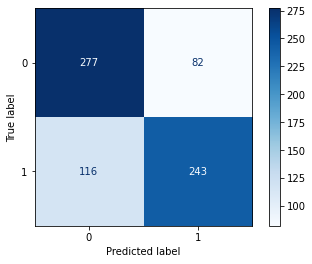

In [154]:
# Support Vector Machine
svc_n = SVC(verbose=10, random_state=42)
svc_n.fit(X_train, y_train)
y_svc_n = svc_n.predict(X_test)
as_svc_n = accuracy_score(y_test, y_svc_n)
f1s_svc_n = f1_score(y_test, y_svc_n, average="macro")
prec_svc_n = precision_score(y_test, y_svc_n)
rec_svc_n = recall_score(y_test, y_svc_n, average='macro')
print("\nSupport Vector Machine - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(svc_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_n)
print(classification_report(y_test,y_svc_n))
print(accuracy_score(y_test, y_svc_n))


Logistic Regression - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.71      0.77      0.74       359
           1       0.75      0.69      0.72       359

    accuracy                           0.73       718
   macro avg       0.73      0.73      0.73       718
weighted avg       0.73      0.73      0.73       718

0.7298050139275766


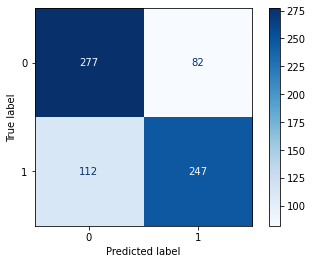

In [155]:
# Logistic
log_fit_n = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_n = log_fit_n.predict(X_test)
as_log_n = accuracy_score(y_test, y_log_n)
f1s_log_n = f1_score(y_test, y_log_n, average= "macro")
prec_log_n = precision_score(y_test, y_log_n)
rec_log_n = recall_score(y_test, y_log_n, average='macro')
print("\nLogistic Regression - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(log_fit_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_n))
print(classification_report(y_test,y_log_n))
print(accuracy_score(y_test, y_log_n))


Random Forest - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.63      0.86      0.73       359
           1       0.79      0.50      0.61       359

    accuracy                           0.68       718
   macro avg       0.71      0.68      0.67       718
weighted avg       0.71      0.68      0.67       718

0.6824512534818942


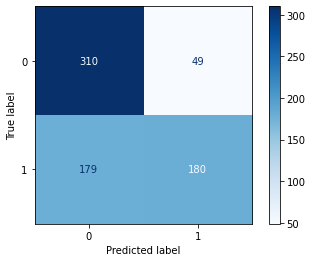

In [156]:
# Random Forest
rf_n = RandomForestClassifier(n_estimators=10, random_state=42)
rf_n.fit(X_train, y_train) 
y_rf_n = rf_n.predict(X_test)
as_rf_n = accuracy_score(y_test, y_rf_n)
f1s_rf_n = f1_score(y_test, y_rf_n, average= "macro")
prec_rf_n = precision_score(y_test, y_rf_n)
rec_rf_n = recall_score(y_test, y_rf_n, average='macro')
print("\nRandom Forest - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(rf_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_n))
print(classification_report(y_test,y_rf_n))
print(accuracy_score(y_test, y_rf_n))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       359
           1       0.71      0.68      0.70       359

    accuracy                           0.70       718
   macro avg       0.70      0.70      0.70       718
weighted avg       0.70      0.70      0.70       718

0.7033426183844012


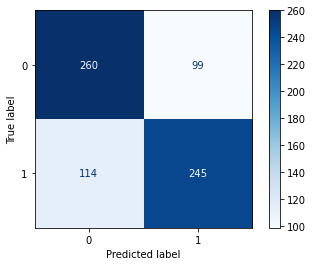

In [157]:
# Neural Networks
NN_n = MLPClassifier(random_state=42, max_iter=30)
NN_n.fit(X_train, y_train)
y_NN_n = NN_n.predict(X_test)
as_NN_n = accuracy_score(y_test, y_NN_n)
f1s_NN_n = f1_score(y_test, y_NN_n, average= "macro")
prec_NN_n = precision_score(y_test, y_NN_n)
rec_NN_n = recall_score(y_test, y_NN_n, average='macro')
print("\nNeural Networks - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(NN_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN_n))
print(classification_report(y_test,y_NN_n))
print(accuracy_score(y_test, y_NN_n))


Decision Tree - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       359
           1       0.71      0.66      0.68       359

    accuracy                           0.69       718
   macro avg       0.70      0.69      0.69       718
weighted avg       0.70      0.69      0.69       718

0.6949860724233984


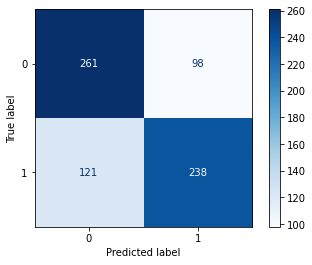

In [158]:
# Decision Tree
tree_n = DecisionTreeClassifier(random_state=42)
tree_n.fit(X_train, y_train)
y_tree_n = tree_n.predict(X_test)
as_tree_n = accuracy_score(y_test, y_tree_n)
f1s_tree_n = f1_score(y_test, y_tree_n, average= "macro")
prec_tree_n = precision_score(y_test, y_tree_n)
rec_tree_n = recall_score(y_test, y_tree_n, average='macro')
print("\nDecision Tree - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(tree_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_n))
print(classification_report(y_test,y_tree_n))
print(accuracy_score(y_test, y_tree_n))


K-Nearest Neighbors - NOUN_PROPN_VERB_ADJ_ADV_DET

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       359
           1       1.00      0.00      0.01       359

    accuracy                           0.50       718
   macro avg       0.75      0.50      0.34       718
weighted avg       0.75      0.50      0.34       718

0.5013927576601671


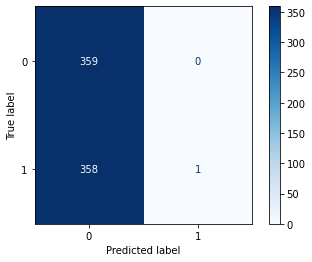

In [159]:
# K-Nearest Neighbors
knn_n = KNeighborsClassifier()
knn_n.fit(X_train, y_train)
y_knn_n = knn_n.predict(X_test)
as_knn_n = accuracy_score(y_test, y_knn_n)
f1s_knn_n = f1_score(y_test, y_knn_n, average= "macro")
prec_knn_n = precision_score(y_test, y_knn_n)
rec_knn_n = recall_score(y_test, y_knn_n, average='macro')
print("\nK-Nearest Neighbors - NOUN_PROPN_VERB_ADJ_ADV_DET\n")
plot_confusion_matrix(knn_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn_n))
print(classification_report(y_test,y_knn_n))
print(accuracy_score(y_test, y_knn_n))

In [160]:
s1_n = pd.Series([as_mnb_n, as_svc_n, as_log_n, as_rf_n, as_NN_n, as_tree_n, as_knn_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_n = pd.Series([f1s_mnb_n, f1s_svc_n, f1s_log_n, f1s_rf_n, f1s_NN_n, f1s_tree_n, f1s_knn_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_n = pd.Series([prec_mnb_n, prec_svc_n, prec_log_n, prec_rf_n, prec_NN_n, prec_tree_n, prec_knn_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_n = pd.Series([rec_mnb_n, rec_svc_n, rec_log_n, rec_rf_n, rec_NN_n, rec_tree_n, rec_knn_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_n = {'Accuracy Score' : s1_n, 'Precision Score': s3_n, 'Recall Score' : s4_n, 'F1 Score' : s2_n}
dfm_n = pd.DataFrame(d_n)
print("\nNOUN_PROPN_VERB_ADJ_ADV_DET\n")
dfm_n.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


NOUN_PROPN_VERB_ADJ_ADV_DET



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.654596,0.632458,0.654596,0.652167
Support Vector Machine,0.724234,0.747692,0.724234,0.723614
Logistic Regression,0.729805,0.750760,0.729805,0.729332
Random Forest,0.682451,0.786026,0.682451,0.671688
Neural Networks,0.703343,0.712209,0.703343,0.703213
Decision Tree,0.694986,0.708333,0.694986,0.694673
K-Nearest Neighbors,0.501393,1.000000,0.501393,0.336421


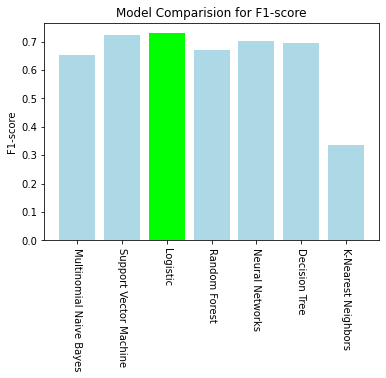

In [161]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors')
y_pos = np.arange(len(objects))
performance = [f1s_mnb_n, f1s_svc_n, f1s_log_n, f1s_rf_n, f1s_NN_n, f1s_tree_n, f1s_knn_n]
clrs = ['lightblue' if (x < max(performance)) else 'lime' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('F1-score')
plt.title('Model Comparision for F1-score')
plt.show()

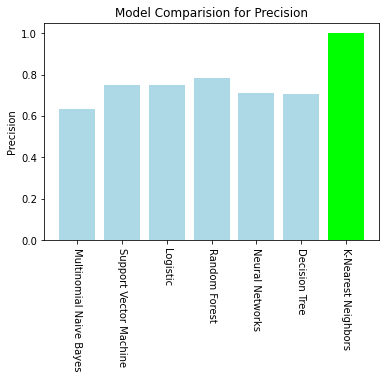

In [162]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors')
y_pos = np.arange(len(objects))
performance = [prec_mnb_n, prec_svc_n, prec_log_n, prec_rf_n, prec_NN_n, prec_tree_n, prec_knn_n]
clrs = ['lightblue' if (x < max(performance)) else 'lime' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('Precision')
plt.title('Model Comparision for Precision')
plt.show()

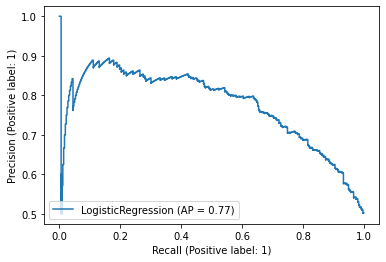

In [163]:
plot_precision_recall_curve(log_fit_n, X_test, y_test)

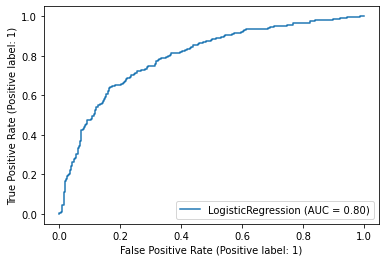

In [164]:
plot_roc_curve(log_fit_n,  X_test, y_test)

## MODEL USING POLARITY AS FEATURE

In [165]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
sentiment_analyzer = VS()
def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    features = [ sentiment['neu'], sentiment['neg']]
    #features = pandas.DataFrame(features)
    return features

In [166]:
def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

In [167]:
final_features = sentiment_analysis_array(data["text_clean"])

In [168]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_npvaad = tfidf_vectorizer.fit_transform(data["text_clean"])
tfidf_a = tfidf_npvaad.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(10694, 14774)

In [169]:
X_f = pd.DataFrame(modelling_features)
y_f = data["label"]
X, y = undersample.fit_resample(X_f, y_f)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y, random_state=42, test_size=0.2)


Multinomoial Naive Bayes - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.76      0.63      0.69       236
           1       0.69      0.81      0.75       243

    accuracy                           0.72       479
   macro avg       0.73      0.72      0.72       479
weighted avg       0.73      0.72      0.72       479

0.7202505219206681


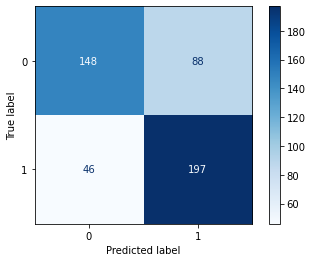

In [170]:
# Multinomial Naive Bayes
mnb_f = MultinomialNB(alpha=0.01)
mnb_f.fit(X_train_f, y_train_f)
y_mnb_f = mnb_f.predict(X_test_f)
as_mnb_f = accuracy_score(y_test_f, y_mnb_f)
f1s_mnb_f = f1_score(y_test_f, y_mnb_f, average= "macro")
prec_mnb_f = precision_score(y_test_f, y_mnb_f)
rec_mnb_f = recall_score(y_test_f, y_mnb_f, average='macro')
print("\nMultinomoial Naive Bayes - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(mnb_f, X_test_f,y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_mnb_f))
print(classification_report(y_test_f,y_mnb_f))
print(accuracy_score(y_test_f, y_mnb_f))

[LibSVM]
Support Vector Machine - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       236
           1       0.71      0.71      0.71       243

    accuracy                           0.70       479
   macro avg       0.70      0.70      0.70       479
weighted avg       0.70      0.70      0.70       479

0.7035490605427975


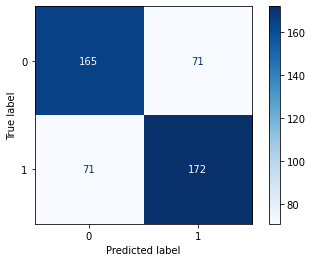

In [171]:
# Support Vector Machine
svc_f = SVC(verbose=10, random_state=42)
svc_f.fit(X_train_f, y_train_f)
y_svc_f = svc_f.predict(X_test_f)
as_svc_f = accuracy_score(y_test_f, y_svc_f)
f1s_svc_f = f1_score(y_test_f, y_svc_f, average="macro")
prec_svc_f = precision_score(y_test_f, y_svc_f)
rec_svc_f = recall_score(y_test_f, y_svc_f, average='macro')
print("\nSupport Vector Machine - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(svc_f, X_test_f,y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_svc_f)
print(classification_report(y_test_f,y_svc_f))
print(accuracy_score(y_test_f, y_svc_f))


Logistic Regression - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       236
           1       0.73      0.72      0.72       243

    accuracy                           0.72       479
   macro avg       0.72      0.72      0.72       479
weighted avg       0.72      0.72      0.72       479

0.7223382045929019


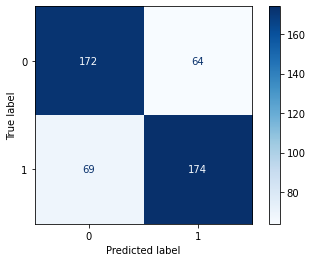

In [172]:
# Logistic
log_fit_f = LogisticRegression(random_state=42).fit(X_train_f, y_train_f)
y_log_f = log_fit_f.predict(X_test_f)
as_log_f = accuracy_score(y_test_f, y_log_f)
f1s_log_f = f1_score(y_test_f, y_log_f, average= "macro")
prec_log_f = precision_score(y_test_f, y_log_f)
rec_log_f = recall_score(y_test_f, y_log_f, average='macro')
print("\nLogistic Regression - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(log_fit_f, X_test_f,y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_log_f))
print(classification_report(y_test_f,y_log_f))
print(accuracy_score(y_test_f, y_log_f))


Random Forest - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       236
           1       0.77      0.60      0.67       243

    accuracy                           0.70       479
   macro avg       0.71      0.71      0.70       479
weighted avg       0.72      0.70      0.70       479

0.7035490605427975


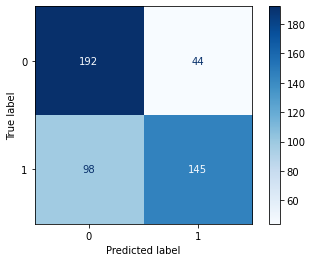

In [173]:
# Random Forest
rf_f = RandomForestClassifier(n_estimators=10, random_state=42)
rf_f.fit(X_train_f, y_train_f) 
y_rf_f = rf_f.predict(X_test_f)
as_rf_f = accuracy_score(y_test_f, y_rf_f)
f1s_rf_f = f1_score(y_test_f, y_rf_f, average= "macro")
prec_rf_f = precision_score(y_test_f,y_rf_f)
rec_rf_f = recall_score(y_test_f, y_rf_f, average='macro')
print("\nRandom Forest - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(rf_f, X_test_f ,y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_rf_f))
print(classification_report(y_test_f ,y_rf_f))
print(accuracy_score(y_test_f, y_rf_f))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       236
           1       0.70      0.72      0.71       243

    accuracy                           0.70       479
   macro avg       0.70      0.70      0.70       479
weighted avg       0.70      0.70      0.70       479

0.6993736951983298


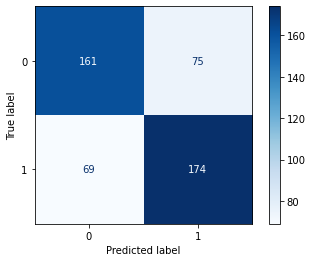

In [174]:
# Neural Networks
NN_f = MLPClassifier(random_state=42, max_iter=30)
NN_f.fit(X_train_f, y_train_f)
y_NN_f = NN_f.predict(X_test_f)
as_NN_f = accuracy_score(y_test_f, y_NN_f)
f1s_NN_f = f1_score(y_test_f, y_NN_f, average= "macro")
prec_NN_f = precision_score(y_test_f, y_NN_f)
rec_NN_f = recall_score(y_test_f, y_NN_f, average='macro')
print("\nNeural Networks - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(NN_f, X_test_f, y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_NN_f))
print(classification_report(y_test_f,y_NN_f))
print(accuracy_score(y_test_f, y_NN_f))


Decision Tree - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       236
           1       0.66      0.66      0.66       243

    accuracy                           0.66       479
   macro avg       0.66      0.66      0.66       479
weighted avg       0.66      0.66      0.66       479

0.6555323590814196


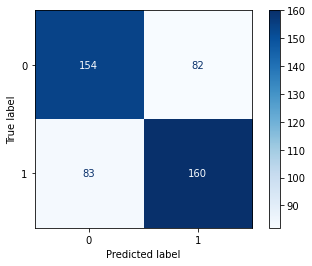

In [175]:
# Decision Tree
tree_f = DecisionTreeClassifier(random_state=42)
tree_f.fit(X_train_f, y_train_f)
y_tree_f = tree_f.predict(X_test_f)
as_tree_f = accuracy_score(y_test_f, y_tree_f)
f1s_tree_f = f1_score(y_test_f, y_tree_f, average= "macro")
prec_tree_f = precision_score(y_test_f, y_tree_f)
rec_tree_f = recall_score(y_test_f, y_tree_f, average='macro')
print("\nDecision Tree - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(tree_f, X_test_f, y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_tree_f))
print(classification_report(y_test_f,y_tree_f))
print(accuracy_score(y_test_f, y_tree_f))


K-Nearest Neighbors - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity

              precision    recall  f1-score   support

           0       0.48      0.84      0.61       236
           1       0.45      0.12      0.19       243

    accuracy                           0.48       479
   macro avg       0.47      0.48      0.40       479
weighted avg       0.47      0.48      0.40       479

0.4780793319415449


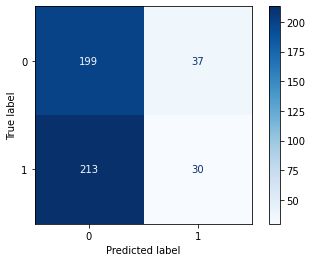

In [176]:
# K-Nearest Neighbors
knn_f = KNeighborsClassifier()
knn_f.fit(X_train_f, y_train_f)
y_knn_f = knn_f.predict(X_test_f)
as_knn_f = accuracy_score(y_test_f, y_knn_f)
f1s_knn_f = f1_score(y_test_f, y_knn_f, average= "macro")
prec_knn_f = precision_score(y_test_f, y_knn_f)
rec_knn_f = recall_score(y_test_f, y_knn_f, average='macro')
print("\nK-Nearest Neighbors - NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
plot_confusion_matrix(knn_f, X_test_f,y_test_f, cmap="Blues")
#print(confusion_matrix(y_test_f,y_knn_f))
print(classification_report(y_test_f,y_knn_f))
print(accuracy_score(y_test_f, y_knn_f))

In [177]:
s1_f = pd.Series([as_mnb_f, as_svc_f, as_log_f, as_rf_f, as_NN_f, as_tree_f, as_knn_f], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_f = pd.Series([f1s_mnb_f, f1s_svc_f, f1s_log_f, f1s_rf_f, f1s_NN_f, f1s_tree_f, f1s_knn_f], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_f = pd.Series([prec_mnb_f, prec_svc_f, prec_log_f, prec_rf_f, prec_NN_f, prec_tree_f, prec_knn_f], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_f = pd.Series([rec_mnb_f, rec_svc_f, rec_log_f, rec_rf_f, rec_NN_f, rec_tree_f, rec_knn_f], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_f = {'Accuracy Score' : s1_f, 'Precision Score': s3_f, 'Recall Score' : s4_f, 'F1 Score' : s2_f}
dfm_f = pd.DataFrame(d_f)
print("\nNOUN_PROPN_VERB_ADJ_ADV_DET with Polarity\n")
dfm_f.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


NOUN_PROPN_VERB_ADJ_ADV_DET with Polarity



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.720251,0.691228,0.718909,0.717292
Support Vector Machine,0.703549,0.707819,0.703486,0.703486
Logistic Regression,0.722338,0.731092,0.722431,0.722333
Random Forest,0.703549,0.767196,0.705134,0.700667
Neural Networks,0.699374,0.698795,0.699126,0.699152
Decision Tree,0.655532,0.661157,0.655489,0.655478
K-Nearest Neighbors,0.478079,0.447761,0.483339,0.403873


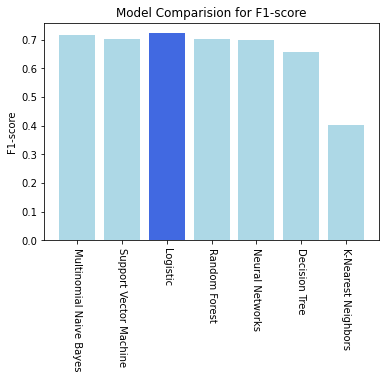

In [178]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors')
y_pos = np.arange(len(objects))
performance = [f1s_mnb_f, f1s_svc_f, f1s_log_f, f1s_rf_f, f1s_NN_f, f1s_tree_f, f1s_knn_f]
clrs = ['lightblue' if (x < max(performance)) else 'royalblue' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('F1-score')
plt.title('Model Comparision for F1-score')
plt.show()

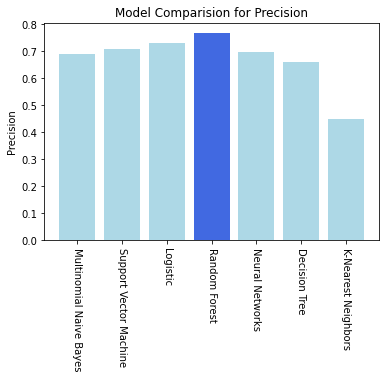

In [179]:
objects = ('Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors')
y_pos = np.arange(len(objects))
performance = [prec_mnb_f, prec_svc_f, prec_log_f, prec_rf_f, prec_NN_f, prec_tree_f, prec_knn_f]
clrs = ['lightblue' if (x < max(performance)) else 'royalblue' for x in performance ]
plt.bar(y_pos, performance, align='center', alpha=1, color=clrs)
plt.xticks(y_pos, objects, rotation=270)
plt.ylabel('Precision')
plt.title('Model Comparision for Precision')
plt.show()

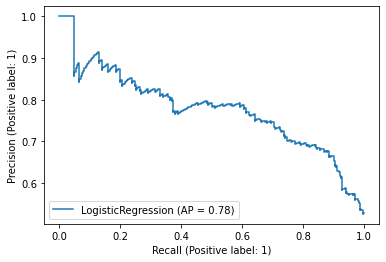

In [180]:
plot_precision_recall_curve(log_fit_f, X_test_f, y_test_f)

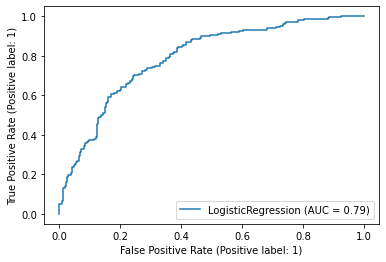

In [181]:
plot_roc_curve(log_fit_f,  X_test_f, y_test_f)

### Sentiment Analysis by nltk VEDER 

In [182]:
sia = vd.SentimentIntensityAnalyzer()
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "ADP", "DET" ]
data["NOUN_PROPN_VERB_ADJ_ADV_ADP_DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPVAAAD'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP_DET"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPVAAAD']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.12401915103473823


In [183]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV",  "DET" ]
data["NOUN_PROPN_VERB_ADJ_ADV_DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPVAAD'] = data["NOUN_PROPN_VERB_ADJ_ADV_DET"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPVAAD']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.12398909070802654


In [184]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "ADP" ]
data["NOUN_PROPN_VERB_ADJ_ADV_ADP"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPVAAA'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPVAAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.12373566074242309


In [185]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV" ]
data["NOUN_PROPN_VERB_ADJ_ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPAA'] = data["NOUN_PROPN_VERB_ADJ_ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.12370556639307816


In [186]:
data['sentiment_NPAA'] = data["NOUN_PROPN_ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.11540417075815557


In [187]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "SCONJ"]
data["NOUN_PROPN_VERB_ADJ_ADV_SCONJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPAA'] = data["NOUN_PROPN_VERB_ADJ_ADV_SCONJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.11527302957565302


In [188]:
data['sentiment_text'] = data["lemmatized"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_text']
correl_text = col1.corr(col2)
print(correl_text)

-0.1143377070801825


In [189]:
pos_list = ["NOUN","PROPN", "ADJ", "ADV" ]
data["NOUN_PROPN_ADJ_ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NPAA'] = data["NOUN_PROPN_ADJ_ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.11070156135571538


In [190]:
data['sentiment_ADJ'] = data["ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADJ']
correl_ADJ = col1.corr(col2)
print(correl_ADJ)

-0.08613958463257142


In [191]:
data['sentiment_NOUN'] = data["NOUN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN']
correl_NOUN = col1.corr(col2)
print(correl_NOUN)

-0.07328006106414722


In [192]:
data['sentiment_VERB'] = data["VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_VERB']
correl_VERB = col1.corr(col2)
print(correl_VERB)

-0.06772608246462664


In [193]:
data['sentiment_PROPN'] = data["PROPN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PROPN']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.049919424170940474


In [194]:
pos_list = ["ADP"]
data["ADP"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_ADP'] = data["ADP"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADP']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.0019612716694508204


In [195]:
data['sentiment_PRON'] = data["PRON"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PRON']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

0.0009543018661945319


In [196]:
data['sentiment_ADV'] = data["ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADV']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

0.004929174365234123


In [197]:
data['sentiment_SCONJ'] = data["SCONJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_SCONJ']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

0.0419899636999094


### Polarity by TextBlob

Text(0, 0.5, 'Number of texts')

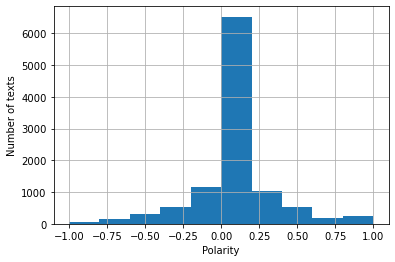

In [198]:
data['polarity'] = data['lemmatized'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity'].unique()
data['polarity'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of texts")

Text(0, 0.5, 'Number of NPAA')

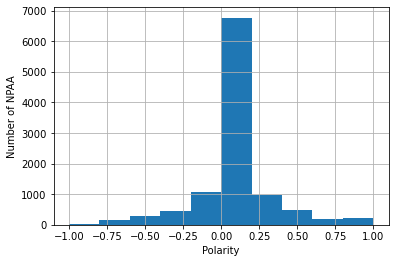

In [199]:
data['polarity_NPAA'] = data["NOUN_PROPN_ADJ_ADV"].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NPAA'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of NPAA")

Text(0, 0.5, 'Number of NPVAASA')

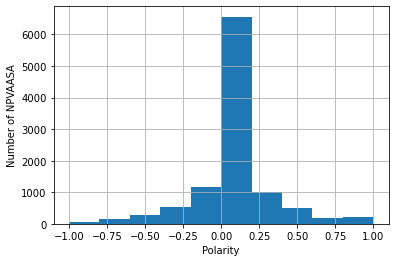

In [200]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "ADP", "SCONJ" ]
data["NOUN_PROPN_VERB_ADJ_ADV_ADP_SCONJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['polarity_NPVAASA'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP_SCONJ"].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NPVAASA'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of NPVAASA")

Text(0, 0.5, 'Number of NPVAAA')

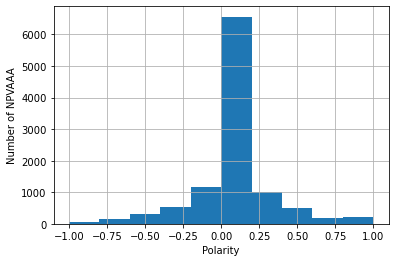

In [201]:
data['polarity_NPVAAA'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP"].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NPVAAA'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of NPVAAA")

Text(0, 0.5, 'Number of Adjectives')

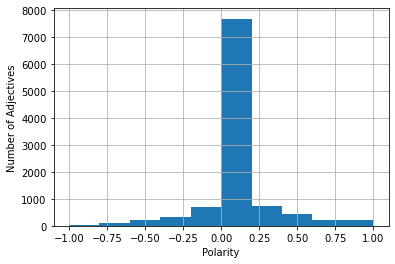

In [202]:
data['polarity_ADJ'] = data['ADJ'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_ADJ'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Adjectives")

Text(0, 0.5, 'Number of Nouns')

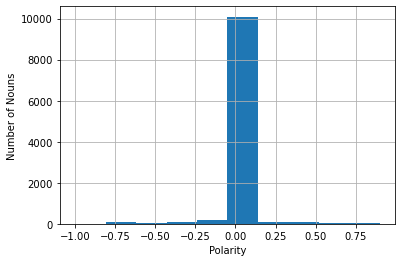

In [203]:
data['polarity_NOUN'] = data['NOUN'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NOUN'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Nouns")

Text(0, 0.5, 'Number of Proper Nouns')

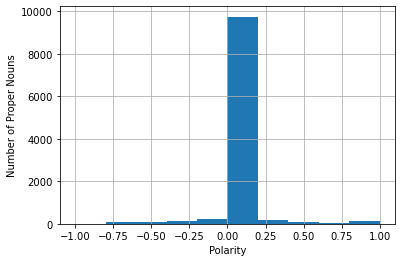

In [204]:
data['polarity_PROPN'] = data['PROPN'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_PROPN'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Proper Nouns")

Text(0, 0.5, 'Number of Verbs')

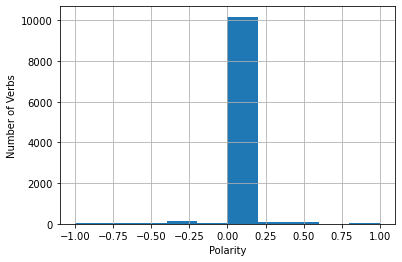

In [205]:
data['polarity_VERB'] = data['VERB'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_VERB'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Verbs")

Text(0, 0.5, 'Number of Adverbs')

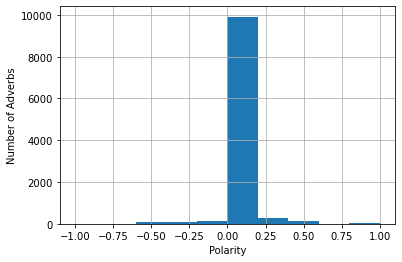

In [206]:
data['polarity_ADV'] = data['ADV'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_ADV'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Adverbs")

Text(0, 0.5, 'Number of Adposition')

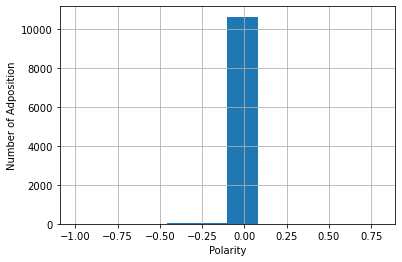

In [207]:
data['polarity_ADP'] = data['ADP'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_ADP'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Adposition")

Text(0, 0.5, 'Number of Pronouns')

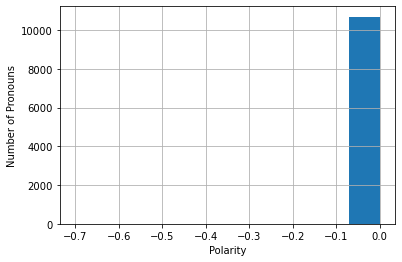

In [208]:
data['polarity_PRON'] = data['PRON'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_PRON'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Pronouns")

Text(0, 0.5, 'Number of Subordinating Conjunctions')

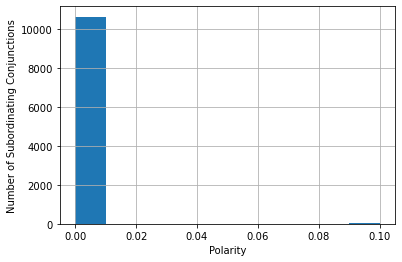

In [209]:
data['polarity_SCONJ'] = data['SCONJ'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_SCONJ'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Subordinating Conjunctions")

Text(0, 0.5, 'Number of Interjection')

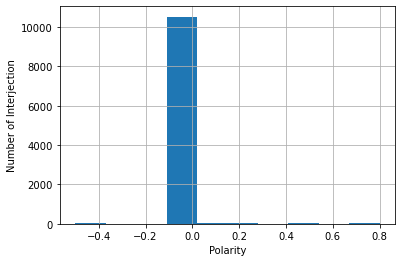

In [210]:
data['polarity_INTJ'] = data['INTJ'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_INTJ'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Interjection")

## Save the `data` df created so far

In [211]:
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

#### Check for punctuation (POS=PUNCT)

In [212]:
pos_list = ["PUNCT"]
data["PUNCT"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data[data['PUNCT'].str.contains(".")].head()

,label,text,text_clean,word_count_before,word_count,word_cleaning,stemmed,lemmatized,tokens,POS_spacy,...,polarity_ADJ,polarity_NOUN,polarity_PROPN,polarity_VERB,polarity_ADV,polarity_ADP,polarity_PRON,polarity_SCONJ,polarity_INTJ,PUNCT
1184,0,I bet all the Ted Pike stuff is on the ADL hit...,bet ted pike stuff adl hit list look start dis...,24,12,12,bet ted pike stuff adl hit list look start dis...,bet ted pike stuff adl hit list look start dis...,"[bet, ted, pike, stuff, adl, hit, list, look, ...","[(bet, PROPN), (ted, PROPN), (pike, PROPN), (s...",...,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,adl
1220,0,:hide And if you 're around Knights of Columbu...,hide around knights columbus roman catholic br...,26,14,12,hide around knight columbu roman cathol brethe...,hide around knight columbus roman catholic bre...,"[hide, around, knight, columbus, roman, cathol...","[(hide, VERB), (around, ADP), (knight, PROPN),...",...,0.1000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,boy
1495,0,The French N.B communities near Quebec especia...,french nb communities near quebec especially w...,12,8,4,french nb commun near quebec especi would white,french nb community near quebec especially wou...,"[french, nb, community, near, quebec, especial...","[(french, PROPN), (nb, PROPN), (community, PRO...",...,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.1,0.0,white
1624,0,For example almost all the 12 year olds last ...,example almost year olds last year dressed wig...,26,11,15,exampl almost year old last year dress wigger ...,example almost year old last year dressed wigg...,"[example, almost, year, old, last, year, dress...","[(example, NOUN), (almost, ADV), (year, NOUN),...",...,0.0500,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,halloween
1901,0,Dumb goyim are a good revenue source .,dumb goyim good revenue source,8,5,3,dumb goyim good revenu sourc,dumb goy good revenue source,"[dumb, goy, good, revenue, source]","[(dumb, ADJ), (goy, PUNCT), (good, ADJ), (reve...",...,0.1625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,goy


In [213]:
pos_list = ["X"]
data["X_POS"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data[data['X_POS'].str.contains(".")]

,label,text,text_clean,word_count_before,word_count,word_cleaning,stemmed,lemmatized,tokens,POS_spacy,...,polarity_NOUN,polarity_PROPN,polarity_VERB,polarity_ADV,polarity_ADP,polarity_PRON,polarity_SCONJ,polarity_INTJ,PUNCT,X_POS
5,0,Booklet updated on Feb. 14th 2014 .,booklet updated feb th,7,4,3,booklet updat feb th,booklet updated feb th,"[booklet, updated, feb, th]","[(booklet, PROPN), (updated, VERB), (feb, PROP...",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,,th
107,0,Obama has membership in Prince Hall ( for blac...,obama membership prince hall blacks lodge beco...,36,16,20,obama membership princ hall black lodg becom n...,obama membership prince hall black lodge becom...,"[obama, membership, prince, hall, black, lodge...","[(obama, PROPN), (membership, NOUN), (prince, ...",...,0.0,-0.166667,0.0,0.0,0.0,0.0,0.0,0.0,,youtube
143,0,BTW - I do not recall seeing a Mars Bar in S.A ?,btw recall seeing mars bar sa,13,6,7,btw recal see mar bar sa,btw recall seeing mar bar sa,"[btw, recall, seeing, mar, bar, sa]","[(btw, ADV), (recall, VERB), (seeing, VERB), (...",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,,sa
459,0,: P + from someone else to Csabi : `` So accor...,p someone else csabi according csabi romanians...,20,10,10,p someon els csabi accord csabi romanian liste...,p someone else csabi according csabi romanian ...,"[p, someone, else, csabi, according, csabi, ro...","[(p, X), (someone, PRON), (else, ADV), (csabi,...",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,,p
489,0,Some candle light a good drink a forbidden f...,candle light good drink forbidden flag wall tr...,20,11,9,candl light good drink forbidden flag wall tri...,candle light good drink forbidden flag wall tr...,"[candle, light, good, drink, forbidden, flag, ...","[(candle, VERB), (light, ADJ), (good, ADJ), (d...",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,,de
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10734,0,I forgot .,forgot,3,1,2,forgot,forgot,[forgot],"[(forgot, X)]",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,,forgot
10736,0,Viva la MayheeKo !,viva la mayheeko,4,3,1,viva la mayheeko,viva la mayheeko,"[viva, la, mayheeko]","[(viva, X), (la, PROPN), (mayheeko, PROPN)]",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,,viva
10740,0,If a white person wants to do well at any kind...,white person wants well kind academic subject ...,42,21,21,white person want well kind academ subject lan...,white person want well kind academic subject l...,"[white, person, want, well, kind, academic, su...","[(white, ADJ), (person, NOUN), (want, VERB), (...",...,0.5,0.000000,0.0,0.3,0.0,0.0,0.0,0.0,,etc etc
10783,0,Q : If Timmy can hop a distance of 2 feet and ...,q timmy hop distance feet makes hops far hop s...,30,13,17,q timmi hop distanc feet make hop far hop star...,q timmy hop distance foot make hop far hop sta...,"[q, timmy, hop, distance, foot, make, hop, far...","[(q, X), (timmy, PROPN), (hop, PROPN), (distan...",...,0.0,0.000000,0.0,0.1,0.0,0.0,0.0,0.0,,q


# N-grams

### Bi-grams

In [214]:
bi = [list(nltk.bigrams(x)) for x in data['tokens']]

In [215]:
from collections import Counter
lista = []
for x in bi:
    if x not in lista:
        lista.append(x)

In [216]:
bi_count = {}
for item in lista:
    for x in item:
        if x in bi_count:
            bi_count[x] +=1
        else:
            bi_count[x] = 1

In [217]:
top_bi = {k: v for k, v in sorted(bi_count.items(), key=lambda item: item[1], reverse=True)[:20]}
top_bi

{('personal', 'message'): 73,
 ('white', 'people'): 70,
 ('look', 'like'): 68,
 ('year', 'old'): 67,
 ('white', 'nationalist'): 62,
 ('would', 'like'): 60,
 ('year', 'ago'): 59,
 ('white', 'woman'): 53,
 ('non', 'white'): 47,
 ('high', 'school'): 39,
 ('can', 'not'): 37,
 ('white', 'race'): 36,
 ('white', 'girl'): 33,
 ('new', 'york'): 32,
 ('last', 'year'): 30,
 ('sound', 'like'): 30,
 ('public', 'school'): 29,
 ('white', 'man'): 29,
 ('one', 'day'): 28,
 ('south', 'africa'): 28}

### Tri-grams

In [218]:
tri = [list(nltk.trigrams(x)) for x in data['tokens']]

In [219]:
lista_tri = []
for x in tri:
    if x not in lista_tri:
        lista_tri.append(x)

In [220]:
tri_count = {}
for item in lista_tri:
    for x in item:
        if x in tri_count:
            tri_count[x] +=1
        else:
            tri_count[x] = 1

In [221]:
top_tri = {k: v for k, v in sorted(tri_count.items(), key=lambda item: item[1], reverse=True)[:20]}
top_tri

{('send', 'personal', 'message'): 10,
 ('hair', 'blue', 'eye'): 9,
 ('new', 'york', 'city'): 8,
 ('dr', 'william', 'pierce'): 8,
 ('like', 'minded', 'people'): 7,
 ('ku', 'klux', 'klan'): 7,
 ('would', 'like', 'say'): 7,
 ('hair', 'brown', 'eye'): 6,
 ('please', 'personal', 'message'): 6,
 ('youtube', 'sa', 'survival'): 6,
 ('sa', 'survival', 'secret'): 6,
 ('survival', 'secret', 'pt'): 6,
 ('secret', 'pt', 'number'): 6,
 ('update', 'pm', 'cst'): 6,
 ('would', 'like', 'get'): 5,
 ('every', 'time', 'see'): 5,
 ('black', 'history', 'month'): 5,
 ('nnn', 'reporter', 'newsroom'): 5,
 ('reporter', 'newsroom', 'forum'): 5,
 ('feel', 'free', 'personal'): 5}